## Часть 1

Представь, что ты главный аналитик в компании и собираешь дашборд с ключевыми метриками (от 4 до 6) для СЕО, на основании которых он будет судить о "здоровье" бизнеса, эффективности текущих операций и т.д. каждый день.  

Исходя из специфики индустрии и бизнес-модели СберМаркета, какие метрики ты бы отразил? Коротко можно объяснить почему.



В 4-6 метрик уложиться сложно - хочется хотя-бы 10, но если строго до 6 - то их я выделил <font color='orange'>цветом</font>.

Все показатели в абсолютных величинах и % относительно предыдущего периода (недели/месяца/года)

**Финансовые показатели**
* Скользящие средние (например за неделю или месяц) <font color='orange'>оборот</font> и <font color='orange'>валовая прибыль</font> (и их соответствие планам/ожиданиям)

**Развитие**
* <font color='orange'>Количество новых клиентов</font> (частных лиц/компаний)
* Удержание клиентов (количество клиентов, совершивших повторный заказ) первой недели/первого месяца.
* <font color='orange'>Отток клиентов</font> (отсутствие покупок постоянного клиента более 1(2) месяцев)
* <font color='orange'>Количество инцидентов</font> (претензий, сбоев, отказов и пр.)
* Количество новых магазитнов-партнеров и охват новых территорий доставки.

**Команда**
* "Укомплектованность" коллектива - наличие не закрытых штатных единиц
* <font color='orange'>Текучка кадров</font> - количество увольнений сотрудников (возможно по категориям работников)

Перечисленные показатели позволят обратить внимание на "проблемные участки" и вовремя принять необходимые решения. 

## Часть 2

Основная задача аналитиков в нашей компании - растить бизнес. Иногда мы сами не знаем где прячутся эти точки кратного роста, поэтому порой приходится кранчить данные и искать зависимости/аномалии, генерировать гипотезы в процессе и потом предлагать проекты. Мы дадим доступ к базе со срезом транзакций. Твое задание: найти все интересные на твой взгляд инсайты и представь их в любом удобном виде (ноутбук желательно приложить).

### Схема таблиц и полей

**orders**
* Id - id заказа
* created_at - timestamp создания заказа на сайте
* delivery_window_id - id слота доставки
* item_total - Сумма всех товаров в корзине (средний чек)
* promo_total - Сумма промо-кода на товары в корзине
* cost - Изначальная стоимость доставки
* total_cost - Финальная стоимость доставки (отличается, если был применен промо-код на доставку. Если промокода не было, то cost=total_cost)
* ship_address_id - id адреса доставки (ключ к addresses.id)
* shipped_at - timestamp доставки заказа
* state - состояние доставки (shipped, canceled и тд)
* store_id - id магазина
* total_quantity - Количество единиц товара
* total_weight - Вес заказа , г.
* user_id - id пользователя

**delivery_windows**
* id - id слота доставки (ключ к orders.delivery_window_id)
* starts_at - timestamp начала слота доставки
* ends_at - timestamp конца слота доставки
* store_id - ID магазина

**stores**
* id - ID магазина
* city - ID города
* retailer_id - ID ритейлера

**addresses**
* id - ID адреса (ключ к orders.ship_address_id)
* lat - latitude
* lon - longitude

*(!!) У нашего бизнеса есть большая проблема с ненайденными товарами: Клиент заказывает товары, но они заканчиваются в магазине к моменту начала сборки. Пользователи, очевидно, очень недовольны таким опытом:*

**replacements**
* item_id - id товара, который был заменен
* order_id - id заказа, в котором была замена
* state - статус (замена)


**cancellations**
* item_id - id товара, который был отменен
* order_id - id заказа, в котором была отмена
* state - статус (отмена)

In [1]:
#!pip install folium
#!pip install psycopg2

In [2]:
import psycopg2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import random
import folium
from folium.plugins import HeatMap
from scipy import stats as st

from IPython.display import display

In [3]:
pd.set_option('display.max_columns', None)
#pd.reset_option('display.max_columns')

sns.set(rc={'figure.figsize':(16, 6)})
pd.set_option('display.max_columns', None)

In [4]:
def buy_num(row):
    '''
    возвращает номер покупки
    '''
    try:
        _date = row['created_at']
        _list = row['u_date_list']
        _list.sort(reverse=False)
        _num = _list.index(_date)
        return _num+1
    except:
        return 'error_buy_num'
    
def rand_offset(row):
    '''
    сдвигает значение столбца col на небольшую случайную величину
    '''
    offset = random.uniform(-1,1)/10000
    return row[col] + offset

In [5]:
conn = psycopg2.connect(host='rc1c-fhrb9f1e0l9g611h.mdb.yandexcloud.net', 
                        port = 6432, 
                        dbname='hr-analytics', 
                        sslmode='require',
                        user='analytics',
                        password='HRanalytics')

orders = pd.read_sql('select * from orders', conn)
delivery = pd.read_sql('select * from delivery_windows', conn)
stores = pd.read_sql('select * from stores', conn)
addresses = pd.read_sql('select * from addresses', conn)
replacements = pd.read_sql('select * from replacements', conn)
cancellations = pd.read_sql('select * from cancellations', conn)

conn.close()
''' #на всякий случай сохраняю загруженные из базы данных таблицы в csv
df_list = [orders, delivery, stores, addresses, replacements, cancellations]
i=1
for _df in df_list:
    _df.to_csv(str(i)+'_sber.csv')
    i+=1
'''

" #на всякий случай сохраняю загруженные из базы данных таблицы в csv\ndf_list = [orders, delivery, stores, addresses, replacements, cancellations]\ni=1\nfor _df in df_list:\n    _df.to_csv(str(i)+'_sber.csv')\n    i+=1\n"

In [6]:
''' #при необходимости можно прочитать csv
orders = pd.read_csv('1_sber.csv')
delivery = pd.read_csv('2_sber.csv')
stores = pd.read_csv('3_sber.csv')
addresses = pd.read_csv('4_sber.csv')
replacements = pd.read_csv('5_sber.csv')
cancellations = pd.read_csv('6_sber.csv')
'''

" #при необходимости можно прочитать csv\norders = pd.read_csv('1_sber.csv')\ndelivery = pd.read_csv('2_sber.csv')\nstores = pd.read_csv('3_sber.csv')\naddresses = pd.read_csv('4_sber.csv')\nreplacements = pd.read_csv('5_sber.csv')\ncancellations = pd.read_csv('6_sber.csv')\n"

In [7]:
'''
for _df in df_list:
    display(_df)
    _df.info()
    print()
    print('Дубликатов:', _df.duplicated().sum())
    print('#'*100)
'''

"\nfor _df in df_list:\n    display(_df)\n    _df.info()\n    print()\n    print('Дубликатов:', _df.duplicated().sum())\n    print('#'*100)\n"

#### orders - заказы

In [8]:
display(orders.head(3))

id  user_id  total_cost   cost  item_total  promo_total  total_weight  \
0  756927   139676         0.0    0.0        5015          0.0         37708   
1  756963   139682         0.0    0.0        7096          0.0         49435   
2  756983    63967       299.0  299.0        2724       -250.0         11590   

   total_quantity    state          shipped_at          created_at  \
0              39  shipped 2018-08-26 15:01:42 2018-08-26 02:06:55   
1              71  shipped 2018-08-26 16:28:41 2018-08-26 05:43:20   
2              32  shipped 2018-08-26 15:09:11 2018-08-26 06:12:13   

   ship_address_id  store_id  delivery_window_id  
0           888330         1              226459  
1           888394         1              226460  
2           888420         1              226459

In [9]:
print('количество заказов:', len(orders.index))
print('кол-во уникальных покупателей:', orders['user_id'].nunique())

количество заказов: 720433
кол-во уникальных покупателей: 257827


#### delivery_windows - слоты доставки

In [10]:
display(delivery.head(3))

store_id      id           starts_at             ends_at      time_zone
0         1  226459 2018-08-26 14:00:00 2018-08-26 16:00:00  Europe/Moscow
1         1  226460 2018-08-26 15:00:00 2018-08-26 17:00:00  Europe/Moscow
2         1  226462 2018-08-26 17:00:00 2018-08-26 19:00:00  Europe/Moscow

In [11]:
print(delivery['store_id'].value_counts())
print()
print(delivery['time_zone'].value_counts())

14     14978
12     14795
21     13682
2      11672
1      11233
       ...  
253      148
259      116
252      115
254      114
317        3
Name: store_id, Length: 72, dtype: int64

Europe/Moscow         182173
Europe/Samara           8852
Asia/Yekaterinburg      6717
Asia/Omsk               6486
Europe/Kaliningrad       115
Name: time_zone, dtype: int64


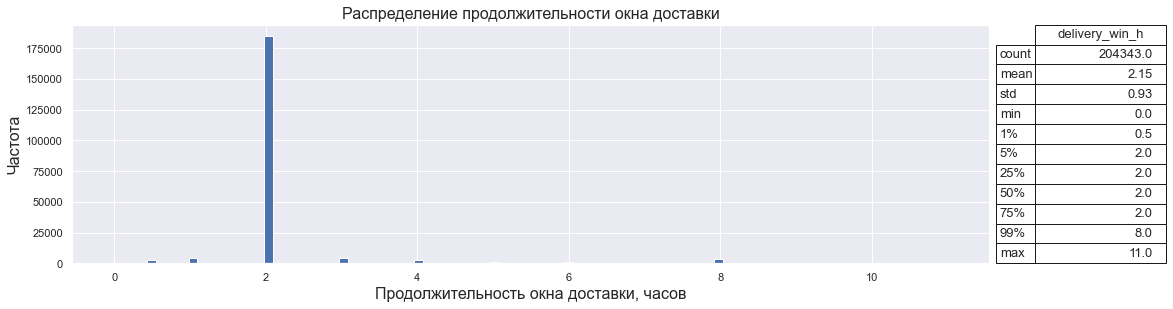

In [12]:
#Продолжительность окна доставки 
delivery['delivery_win_h'] = (delivery['ends_at'] - delivery['starts_at']).dt.total_seconds()/60/60

ser = delivery['delivery_win_h']
    
fig, ax = plt.subplots(1, 2, gridspec_kw={'width_ratios': [7, 1]}, figsize=(16,4))
fig.tight_layout()
    
ax[0].hist(ser, bins=100) #, range=[ser.quantile(0.01), ser.quantile(0.99)]
ax[0].set_title('Распределение продолжительности окна доставки', fontsize=16)
ax[0].set_ylabel('Частота', fontsize=16)
ax[0].set_xlabel('Продолжительность окна доставки, часов', fontsize=16)
    
dfxx = ser.describe(percentiles =[.01, .05, .25, .50, .75, .99]).to_frame().round(2)
ax[1].axis('off')
mpl_table = ax[1].table(cellText = dfxx.values, rowLabels = dfxx.index, bbox=[0, 0, 1, 1], colLabels=dfxx.columns)
mpl_table.auto_set_font_size(False)
mpl_table.set_fontsize(13)

In [13]:
delivery[delivery['delivery_win_h']<0.5]

store_id      id           starts_at             ends_at  \
22064         2  947092 2019-12-12 06:00:00 2019-12-12 06:00:00   
22607         2  947093 2019-12-12 06:00:00 2019-12-12 06:00:00   

           time_zone  delivery_win_h  
22064  Europe/Moscow             0.0  
22607  Europe/Moscow             0.0

* для двух строк продолжительность слота доставки = 0 (начало слота доставки совпадает с концом слота доставки)

In [14]:
#дальше не использую
delivery = delivery.drop('delivery_win_h', axis=1)

#### stores

In [15]:
display(stores.head(3))

id  city  retailer_id
0   1     1            1
1   2     1            1
2   3     1            1

In [16]:
print(stores['city'].value_counts())
print()
print(stores['retailer_id'].value_counts())

1     106
7      14
5      11
13      9
10      8
2       8
8       6
Name: city, dtype: int64

16    43
15    41
8     35
1     28
59    14
61     1
Name: retailer_id, dtype: int64


#### adresses

In [17]:
display(addresses.head(3))
print('Дубликатов в addresses:', addresses.duplicated().sum(),
      '({:.1%})'.format(addresses.duplicated().sum()/len(addresses.index)))

lat        lon      id elevator floor
0  55.851604  37.634282  887760     None    13
1  55.855683  37.644165  888330     None     3
2  55.868020  37.671917  888379     None     -

Дубликатов в addresses: 17660 (1.2%)


In [18]:
#без жалости удаляем полностью идентичные строки
addresses = addresses.drop_duplicates()

### Объединение таблиц

In [19]:
orders_merged = orders.merge(delivery, how='left', left_on='delivery_window_id', right_on='id', suffixes=('', '_d'))
#orders_merged.isna().sum()

* есть 4 значения ключа delivery_window_id (таблица orders) для которых нет соответствия в delivery.

In [20]:
#удаляю пропуски
_len = len(orders_merged.index)
orders_merged = orders_merged.dropna()
_len2 = len(orders_merged.index)
print('Потеряли строк:', _len-_len2, '({:.3%})'.format((_len-_len2)/_len))

Потеряли строк: 4 (0.001%)


In [21]:
orders_merged = orders_merged.merge(stores, how='left', left_on='store_id', right_on='id', suffixes=('', '_s'))
#orders_merged.isna().sum()

In [22]:
orders_merged = orders_merged.merge(addresses, how='left', left_on='ship_address_id', right_on='id', suffixes=('', '_a'))
#orders_merged.isnull().sum()

_len = len(orders_merged.index)
orders_merged = orders_merged.dropna(subset=['id_a']).drop(['id_a'], axis=1)
#orders_merged.drop(['id_a'], axis=1, inplace=True)
_len2 = len(orders_merged.index)
print('Потеряли строк:', _len-_len2, '({:.2%})'.format((_len-_len2)/_len))

Потеряли строк: 46 (0.01%)


In [23]:
#удаляю задвоенные после merge столбцы
orders_merged.drop(['store_id_d', 'id_d', 'id_s'], axis=1, inplace=True)
orders_merged.sample(3)

id  user_id  total_cost   cost  item_total  promo_total  \
32171   3566827   240425       299.0  299.0        2935          0.0   
143851  1465038   123890       354.0  404.0       10383          0.0   
556538  2332421   243437        99.0   99.0        6479          0.0   

        total_weight  total_quantity    state          shipped_at  \
32171          11880              18  shipped 2019-11-12 20:36:48   
143851         70335             134  shipped 2019-05-17 07:31:46   
556538         11138              43  shipped 2019-09-14 17:16:02   

                created_at  ship_address_id  store_id  delivery_window_id  \
32171  2019-11-05 16:40:56          4931206         1              854186   
143851 2019-05-16 08:37:03          1953668         8              507567   
556538 2019-09-14 13:10:24          3126484        89              714334   

                 starts_at             ends_at      time_zone  city  \
32171  2019-11-12 19:00:00 2019-11-12 21:00:00  Europe/Moscow     1   
143851 2019-05-17 06:00:00 2019-05-17 08:00:00  Europe/Moscow     1   
556538 2019-09-14 16:00:00 2019-09-14 18:00:00  Europe/Moscow     7   

        retailer_id        lat        lon   elevator floor  
32171             1  55.823819  37.646199  passenger     5  
143851            1  55.781073  37.687441       None     -  
556538            1  47.264794  39.658945  passenger     5

По геоданным из adresses определил соответствие ключа "city" городу.

**Города:**
* 1 - Москва, 
* 7 - Ростов-на-Дону 
* 10 - Самара
* 2 - Казань
* 5 - Нижний Новгород
* 8 - Уфа
* 13 - Омск

In [24]:
city = pd.DataFrame({'city': [1, 7, 10, 2, 5, 8, 13],
                     'city_name': ['Moscow', 'Rostov-on-Don','Samara', 'Kazan', 'Nizhny Novgorod', 'Ufa', 'Omsk']})
city

city        city_name
0     1           Moscow
1     7    Rostov-on-Don
2    10           Samara
3     2            Kazan
4     5  Nizhny Novgorod
5     8              Ufa
6    13             Omsk

In [25]:
orders_merged = orders_merged.merge(city, how='left', on='city')

**Промежуточные выводы:**
* для двух заказов продолжительность слота доставки = 0 (начало слота доставки совпадает с концом слота доставки)
* в delivery не хватает данных по 4 заказам
* в addresses 17660 (1,2%) дубликатов 
* в addresses нет 46 значений из orders

### Формирование вычисляемых столбцов

In [26]:
#срок доставки (от момента заказа)
orders_merged['delivery_time_h'] = (orders_merged['shipped_at'] - orders_merged['created_at']).dt.total_seconds()/60/60

In [27]:
#попадание в окно доставки
orders_merged['deliv_late_h'] = 0

late = orders_merged['shipped_at'] > orders_merged['ends_at'] #доставлено с опазданием
early = orders_merged['shipped_at'] < orders_merged['starts_at'] #доставлено раньше срока

orders_merged.loc[late,'deliv_late_h'] = (
    orders_merged[late]['shipped_at'] - orders_merged[late]['ends_at']).dt.total_seconds()/60/60
orders_merged.loc[early,'deliv_late_h'] = (
    orders_merged[early]['shipped_at']-orders_merged[early]['starts_at']).dt.total_seconds()/60/60

In [28]:
#год и месяц заказа
orders_merged['yearmonth'] = orders_merged['created_at'].dt.to_period('M')

In [29]:
#день недели заказа и доставки
orders_merged['cr_weekday'] = orders_merged['created_at'].dt.weekday
orders_merged['sh_weekday'] = orders_merged['shipped_at'].dt.weekday

### Анализ

#### Тепловая карта корреляции

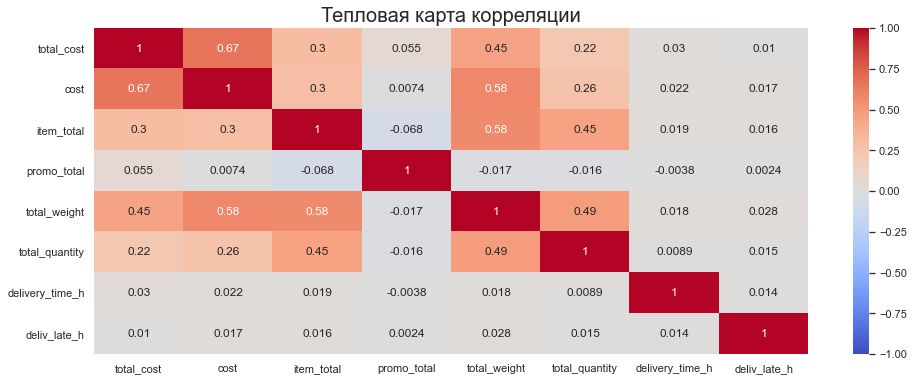

In [30]:
orders_corr = orders_merged[['total_cost', 'cost', 'item_total', 'promo_total', 'total_weight', 'total_quantity',
                             'delivery_time_h', 'deliv_late_h']].copy()

fig, ax = plt.subplots(figsize=(16,6))
sns.heatmap(orders_corr.corr(), annot = True, vmin=-1, vmax=1, center= 0, cmap= 'coolwarm', fmt='.2g')
plt.title('Тепловая карта корреляции', fontsize=20);

* стоимость доставки (полная и со скидкой) наиболее заметно коррелирует с весом заказа.

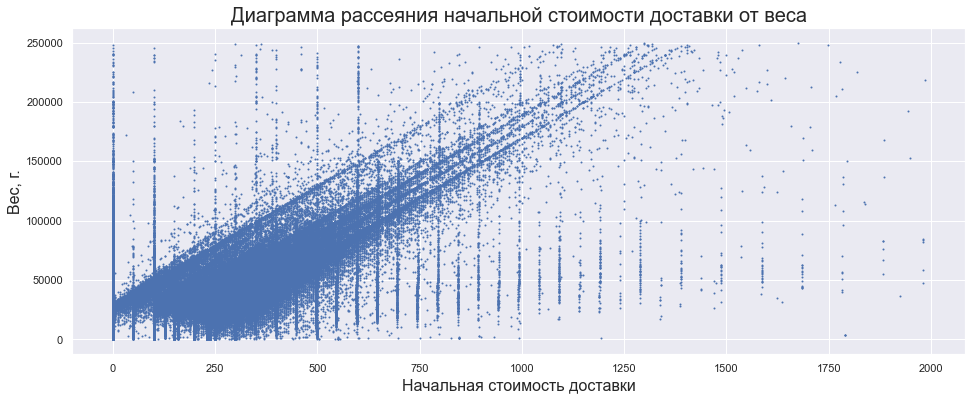

In [31]:
plt.figure(figsize=(16, 6))
df = orders.query('cost<2000 and total_weight<250000')
plt.scatter(df['cost'], df['total_weight'], s=1)
plt.title('Диаграмма рассеяния начальной стоимости доставки от веса', fontsize=20)
plt.ylabel('Вес, г.', fontsize=16)
plt.xlabel('Начальная стоимость доставки', fontsize=16);

Красиво! Можно выделить явные особенности (например средствами sklearn), но в данном случае для поиска зависимостей и "расшифровки" имело бы смысл обратиться к условиям/тарифам доставки.

#### Общая картина

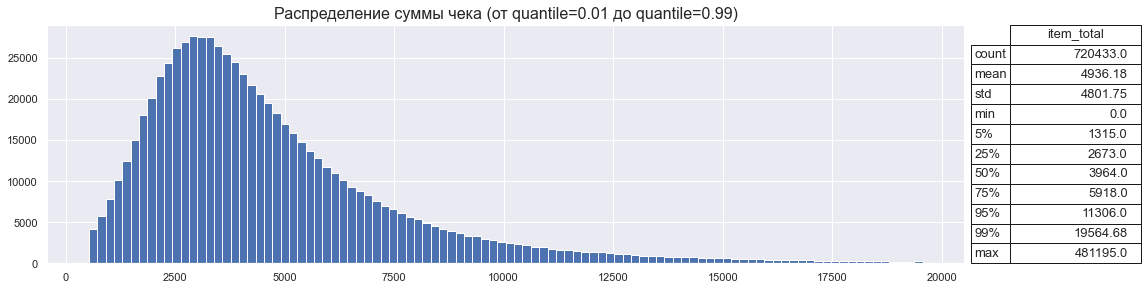

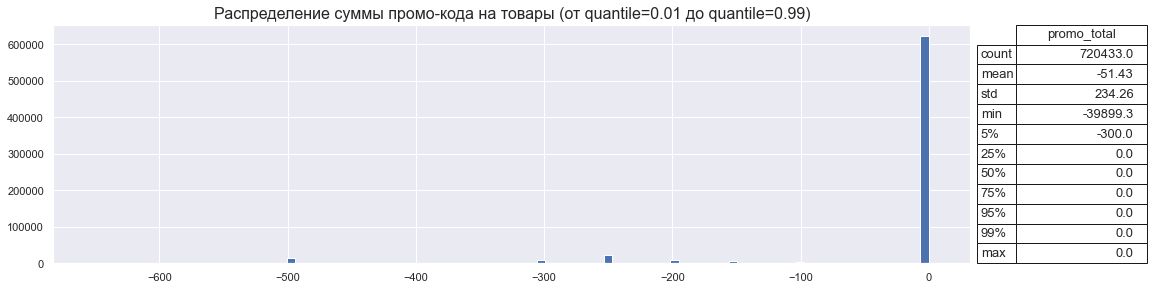

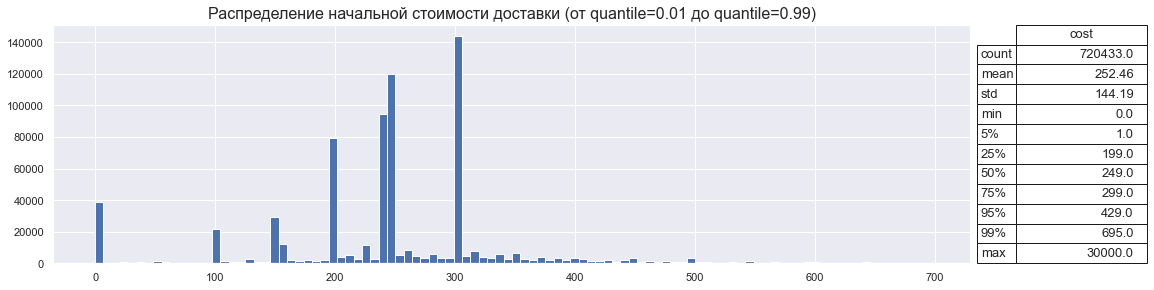

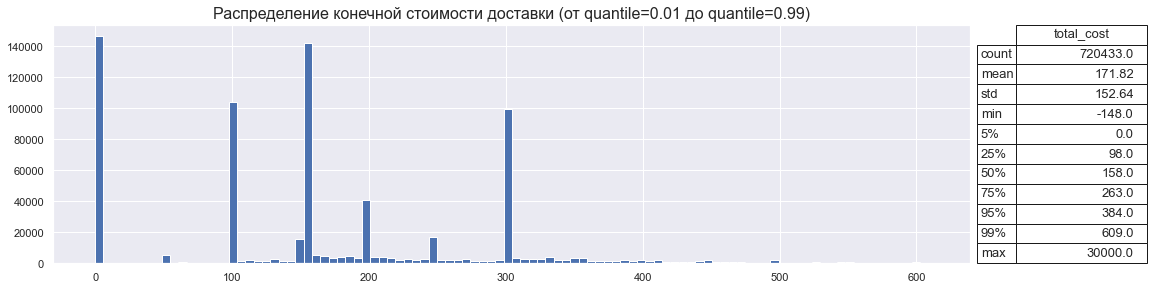

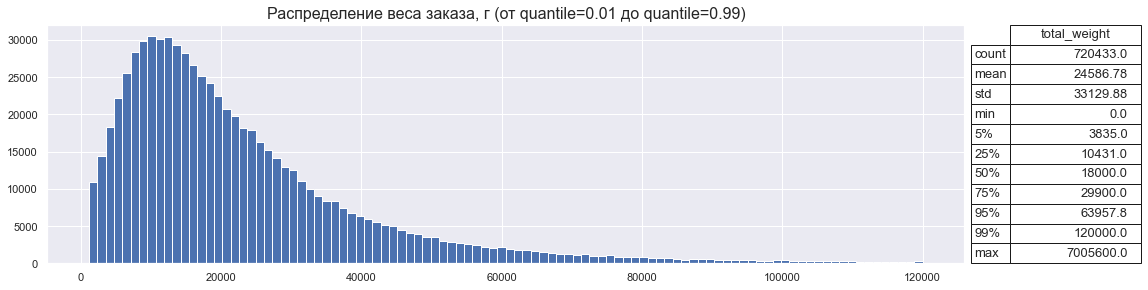

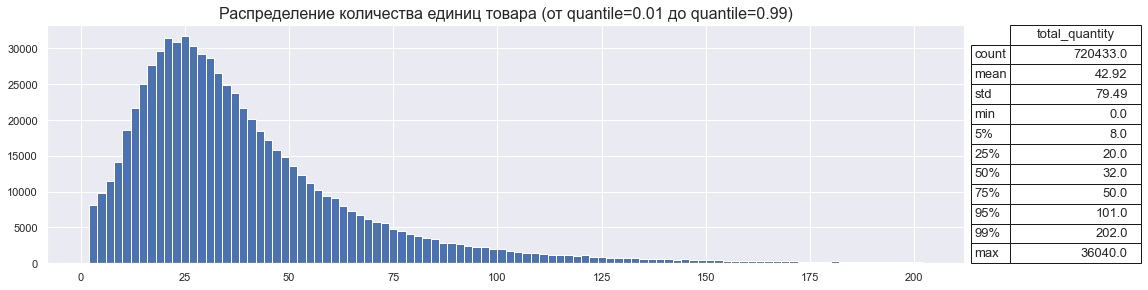

In [32]:
col_list = ['item_total', 'promo_total',  'cost', 'total_cost', 'total_weight', 'total_quantity']
col_name_list = ['суммы чека', 'суммы промо-кода на товары', 'начальной стоимости доставки', 
                 'конечной стоимости доставки', 'веса заказа, г', 'количества единиц товара']
for i in range (len(col_list)):
    ser = orders[col_list[i]]
    
    fig, ax = plt.subplots(1, 2, gridspec_kw={'width_ratios': [7, 1]}, figsize=(16,4))
    fig.tight_layout()
    
    ax[0].hist(ser, bins=100, range=[ser.quantile(0.01), ser.quantile(0.99)])
    ax[0].set_title('Распределение ' + col_name_list[i] + ' (от quantile=0.01 до quantile=0.99)', fontsize=16)
    
    dfxx = ser.describe(percentiles =[.05, .25, .50, .75, .95, .99]).to_frame().round(2)
    ax[1].axis('off')
    mpl_table = ax[1].table(cellText = dfxx.values, rowLabels = dfxx.index, bbox=[0, 0, 1, 1], colLabels=dfxx.columns)
    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(13)

In [33]:
#нулевая сумма товаров в корзине
orders.query('item_total==0')

id  user_id  total_cost   cost  item_total  promo_total  \
25087   2457003   777240         0.0    0.0           0          0.0   
81574   2828415  1112015         0.0  299.0           0          0.0   
108509  1631533   416183         0.0  299.0           0          0.0   
320701  5126949  1758530        98.0  249.0           0       -199.0   
326495   881444   173854         0.0  299.0           0          0.0   
444602  2094365   674612         0.0    0.0           0          0.0   
504839  3838920  1410293       199.0  199.0           0          0.0   
701620  1528533   353833        99.0  149.0           0          0.0   
716938  5004403  1727727        99.0  199.0           0          0.0   

        total_weight  total_quantity    state          shipped_at  \
25087            500               4  shipped 2019-09-24 13:33:58   
81574           4625              13  shipped 2019-10-20 10:04:05   
108509         18000              18  shipped 2019-06-21 14:17:06   
320701         10950              11  shipped 2019-12-11 05:46:06   
326495           705               3  shipped 2018-10-30 05:50:49   
444602          3385              15  shipped 2019-08-25 17:24:13   
504839          5810               7  shipped 2019-11-11 09:12:57   
701620          3723              16  shipped 2019-06-01 04:41:19   
716938         11771              18  shipped 2019-12-08 07:51:02   

                created_at  ship_address_id  store_id  delivery_window_id  
25087  2019-09-24 10:10:43          3520882         1              732756  
81574  2019-10-18 20:58:03          4082440         2              796140  
108509 2019-06-21 09:52:24          2213321         3              561538  
320701 2019-12-10 20:02:23          6751812        12              943952  
326495 2018-10-29 16:01:04          1104838        14              282229  
444602 2019-08-25 13:26:08          2938463        70              675904  
504839 2019-11-09 07:23:24          5203891        63              852220  
701620 2019-05-30 15:04:09          1772737       108              530572  
716938 2019-12-08 03:53:15          6378487       169              932160

In [34]:
#отрицательная финальная стоимость доставки
orders.query('total_cost<0')

id  user_id  total_cost   cost  item_total  promo_total  \
240505  802572    60247      -148.0  299.0        5615          0.0   
381924  795110     4585       -99.0  497.0        3424          0.0   
382148  802465    19214       -99.0  299.0        2139          0.0   

        total_weight  total_quantity    state          shipped_at  \
240505         35357              43  shipped 2018-09-20 14:36:11   
381924         17877              64  shipped 2018-10-10 17:31:12   
382148         35228              31  shipped 2018-09-20 12:11:22   

                created_at  ship_address_id  store_id  delivery_window_id  
240505 2018-09-19 04:12:17           274349        11              247485  
381924 2018-09-15 12:18:13           940822        21              264264  
382148 2018-09-18 22:45:05           858935        21              247582

In [35]:
#процент заказов со скидкой на товары в корзине
len(orders.query('promo_total!=0'))/len(orders)

0.13580443982993562

In [36]:
#стоимость доставки > 10000
orders.query('cost>10000')

id  user_id  total_cost     cost  item_total  promo_total  \
223382  2687784  1045400     25000.0  25000.0      193581          0.0   
226181  3087368  1045400     30000.0  30000.0      262147          0.0   
412663  3166581    59134     10019.0  10019.0       40284          0.0   
492445  4025358  1456775     11455.0  11455.0      282203          0.0   

        total_weight  total_quantity    state          shipped_at  \
223382       4375140            3657  shipped 2019-10-10 21:04:04   
226181       7005600            6370  shipped 2019-10-30 05:54:57   
412663       2004000            4008  shipped 2019-10-30 12:55:21   
492445       2002600            1009  shipped 2019-11-15 13:21:04   

                created_at  ship_address_id  store_id  delivery_window_id  
223382 2019-10-10 09:47:01          3855990        10              770964  
226181 2019-10-25 13:49:55          3986636        10              815827  
412663 2019-10-29 11:16:36          4460074        21              821149  
492445 2019-11-13 13:28:09          5373851        62              862789

In [37]:
#единиц товара > 10000
orders.query('total_quantity>10000')

id  user_id  total_cost   cost  item_total  promo_total  \
374655  4884765    56017       158.0  249.0       76976          0.0   
410838  2755501  1059879         0.0  846.0       25708          0.0   

        total_weight  total_quantity    state          shipped_at  \
374655        853072           10129  shipped 2019-12-08 04:40:30   
410838        200000           36040  shipped 2019-10-18 09:02:36   

                created_at  ship_address_id  store_id  delivery_window_id  
374655 2019-12-05 10:32:41          6445135        14              926890  
410838 2019-10-15 06:49:57          3977452        21              791510

In [38]:
#тяжелые заказы
#orders.query('total_weight>1500000')

Ничего интересного не вижу.

**Промежуточные выводы:**
* 9 заказов с чеком = 0 - причина-? (отказы/возвраты?)
* 3 заказа с отрицательной финальной стоимостью доставки
* Для user_id==1045400 две доставки с высокой круглой ценой (25000 и 30000)
* 1% заказов с весом от 120кг. до 7 тонн.
* Есть заказы с большим количеством единиц товара и небольшим весом (возможно единица товара весом 5г. - это порционная соль/сахар/перец)

#### Покупатели

In [39]:
#группировка по user_id
user_orders = orders.pivot_table(index=['user_id'], aggfunc={'cost': 'mean', 
                                                             'created_at': ('count', list, max, min),
                                                             'item_total': ('mean', sum),
                                                             'store_id': pd.Series.nunique,
                                                             'total_cost': 'mean',
                                                             'total_quantity': 'mean',
                                                             'total_weight': 'mean'})
user_orders.set_axis(['u_cost_mean', 'u_order_count', 'u_date_list', 'u_last_order_at', 'u_first_order_at', 
                      'u_item_mean', 'u_item_sum', 'store_count', 'total_cost_mean', 'u_quantity_mean', 
                      'u_weight_mean'], axis='columns', inplace=True)
display(user_orders.head(3))

u_cost_mean  u_order_count  \
user_id                               
31        368.902439             41   
45        274.806452             31   
63        249.000000              1   

                                               u_date_list  \
user_id                                                      
31       [2019-01-23 20:01:48, 2019-01-17 08:33:47, 201...   
45       [2018-09-15 18:38:46, 2018-09-26 10:24:06, 201...   
63                                   [2018-09-22 09:28:06]   

            u_last_order_at    u_first_order_at   u_item_mean  u_item_sum  \
user_id                                                                     
31      2019-12-09 20:53:19 2018-09-04 19:25:37  13757.146341    564043.0   
45      2019-12-12 10:56:23 2018-09-15 18:38:46   3033.709677     94045.0   
63      2018-09-22 09:28:06 2018-09-22 09:28:06   5789.000000      5789.0   

         store_count  total_cost_mean  u_quantity_mean  u_weight_mean  
user_id                                                                
31                 3       247.560976        78.975610   51403.780488  
45                 1       238.258065        19.612903    8758.967742  
63                 1       249.000000        18.000000   16194.000000

In [40]:
user_orders = user_orders[['u_order_count', 'store_count','u_item_sum', 'u_item_mean', 'u_cost_mean', 'total_cost_mean', 
                           'u_quantity_mean', 'u_weight_mean', 'u_date_list', 'u_first_order_at', 'u_last_order_at']]

In [41]:
user_orders.describe()

u_order_count    store_count    u_item_sum    u_item_mean  \
count  257827.000000  257827.000000  2.578270e+05  257827.000000   
mean        2.794250       1.138690  1.379292e+04    4541.230072   
std         5.169058       0.404199  4.256599e+04    4279.099824   
min         1.000000       1.000000  0.000000e+00       0.000000   
25%         1.000000       1.000000  2.988000e+03    2516.775000   
50%         1.000000       1.000000  5.647000e+03    3676.666667   
75%         3.000000       1.000000  1.297500e+04    5422.928571   
max       493.000000      35.000000  8.510330e+06  376684.000000   

         u_cost_mean  total_cost_mean  u_quantity_mean  u_weight_mean  
count  257827.000000    257827.000000    257827.000000   2.578270e+05  
mean      250.554987       132.215397        38.163853   2.257430e+04  
std       134.877404       124.627007        90.647116   2.641743e+04  
min         0.000000       -49.500000         0.000000   0.000000e+00  
25%       199.000000        49.000000        18.000000   9.640000e+03  
50%       249.000000        99.500000        29.666667   1.676333e+04  
75%       299.000000       182.480769        46.000000   2.754000e+04  
max     10000.000000     10000.000000     36040.000000   2.291950e+06

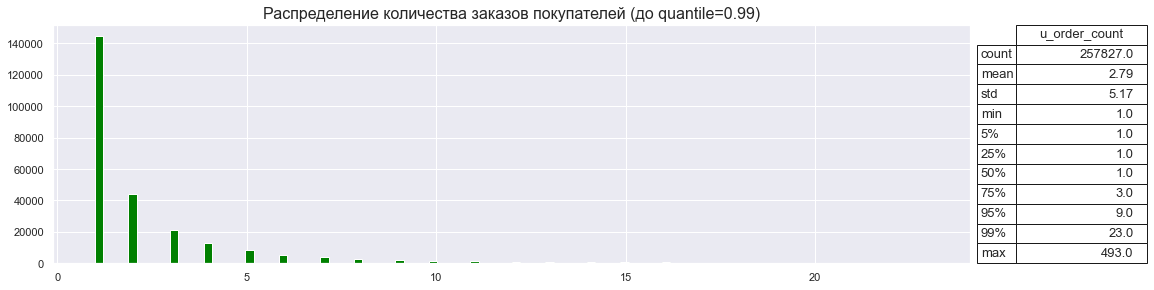

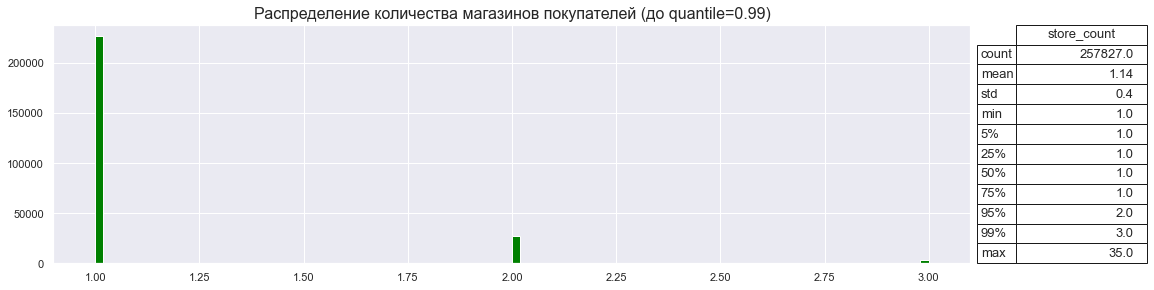

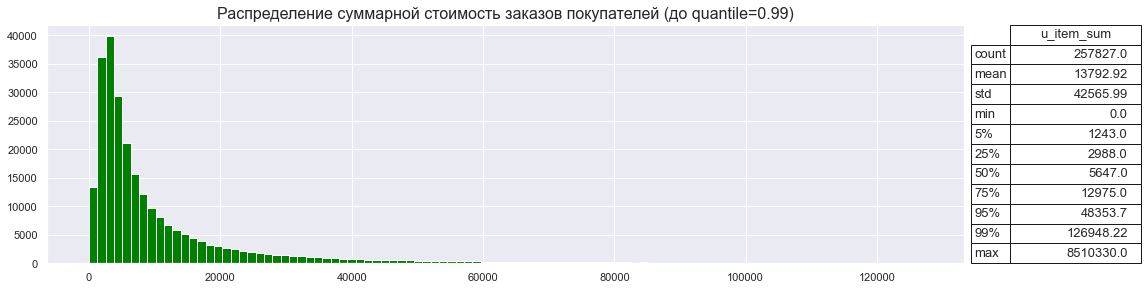

In [42]:
col_list = ['u_order_count', 'store_count', 'u_item_sum']
col_name_list = ['количества заказов', 'количества магазинов', 'суммарной стоимость заказов']
for i in range (len(col_list)):
    ser = user_orders[col_list[i]] #столбец из df
    
    fig, ax = plt.subplots(1, 2, gridspec_kw={'width_ratios': [7, 1]}, figsize=(16,4))
    fig.tight_layout()
    
    ax[0].hist(ser, bins=100, color='green', range=[ser.min(), ser.quantile(0.99)])
    ax[0].set_title('Распределение ' + col_name_list[i] + ' покупателей (до quantile=0.99)', fontsize=16)
    
    dfxx = ser.describe(percentiles =[.05, .25, .50, .75, .95, .99]).to_frame().round(2)
    ax[1].axis('off')
    mpl_table = ax[1].table(cellText = dfxx.values, rowLabels = dfxx.index, bbox=[0, 0, 1, 1], colLabels=dfxx.columns)
    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(13)

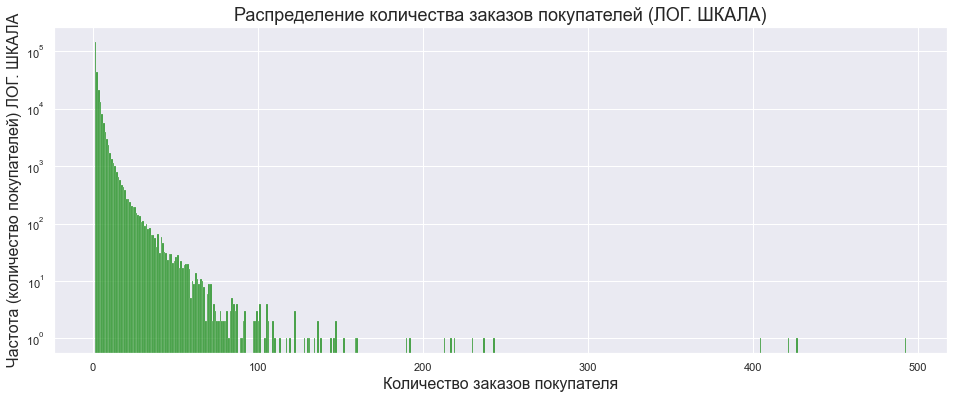

In [43]:
fig, ax = plt.subplots()
ax.set(yscale='log')
sns.histplot(user_orders['u_order_count'], bins=493, color='green')
plt.title('Распределение количества заказов покупателей (ЛОГ. ШКАЛА)', fontsize=18) 
plt.ylabel('Частота (количество покупателей) ЛОГ. ШКАЛА', fontsize=16)
plt.xlabel('Количество заказов покупателя', fontsize=16);

In [44]:
#нумерую заказы каждого покупателя по очередности
orders_merged = orders_merged.merge(user_orders['u_date_list'], on=['user_id'], how='left')
orders_merged['buy_num'] = orders_merged.apply(buy_num, axis=1)
orders_merged = orders_merged.drop('u_date_list', axis=1)

orders_merged[orders_merged['user_id']==215536]

id  user_id  total_cost   cost  item_total  promo_total  \
380001  1027706   215536       149.0  149.0        1971          0.0   
380002  1027714   215536       149.0  149.0        4284          0.0   
380003  1028552   215536       199.0  199.0        3079          0.0   
380005  1030465   215536       199.0  199.0        4285          0.0   
380006  1030597   215536       199.0  199.0        1880          0.0   
...         ...      ...         ...    ...         ...          ...   
380651  5260382   215536       199.0  199.0        7788          0.0   
380652  5295632   215536       199.0  199.0       11717          0.0   
380653  5338384   215536       199.0  199.0       10499          0.0   
380654  5376399   215536       199.0  199.0        7488          0.0   
380655  5415656   215536       199.0  199.0        6895          0.0   

        total_weight  total_quantity    state          shipped_at  \
380001          9300              18  shipped 2019-01-01 17:04:01   
380002         24300              23  shipped 2019-01-01 17:08:41   
380003         12975              20  shipped 2019-01-02 05:38:04   
380005         12975              20  shipped 2019-01-02 21:03:59   
380006         12900              20  shipped 2019-01-03 04:02:38   
...              ...             ...      ...                 ...   
380651         17150             109  shipped 2019-12-14 06:04:04   
380652         26150             109  shipped 2019-12-15 06:04:02   
380653         26150             109  shipped 2019-12-16 06:05:50   
380654         17150             109  shipped 2019-12-17 06:07:30   
380655         17150             109  shipped 2019-12-18 06:04:02   

                created_at  ship_address_id  store_id  delivery_window_id  \
380001 2019-01-01 17:03:39          1348766        18              352627   
380002 2019-01-01 17:08:24          1348785        18              352627   
380003 2019-01-02 05:37:18          1350249        18              353661   
380005 2019-01-02 21:03:26          1353483        18              354897   
380006 2019-01-03 04:01:55          1353689        18              354898   
...                    ...              ...       ...                 ...   
380651 2019-12-14 06:02:14          6917843        18              954979   
380652 2019-12-15 06:02:10          6962257        18              958723   
380653 2019-12-16 06:04:00          7017687        18              962470   
380654 2019-12-17 06:05:43          7065337        18              966214   
380655 2019-12-18 06:02:12          7111984        18              969984   

                 starts_at             ends_at      time_zone  city  \
380001 2019-01-01 20:00:00 2019-01-01 22:00:00  Europe/Moscow     1   
380002 2019-01-01 20:00:00 2019-01-01 22:00:00  Europe/Moscow     1   
380003 2019-01-02 07:00:00 2019-01-02 09:00:00  Europe/Moscow     1   
380005 2019-01-03 05:00:00 2019-01-03 07:00:00  Europe/Moscow     1   
380006 2019-01-03 06:00:00 2019-01-03 08:00:00  Europe/Moscow     1   
...                    ...                 ...            ...   ...   
380651 2019-12-14 08:00:00 2019-12-14 10:00:00  Europe/Moscow     1   
380652 2019-12-15 08:00:00 2019-12-15 10:00:00  Europe/Moscow     1   
380653 2019-12-16 08:00:00 2019-12-16 10:00:00  Europe/Moscow     1   
380654 2019-12-17 08:00:00 2019-12-17 10:00:00  Europe/Moscow     1   
380655 2019-12-18 08:00:00 2019-12-18 10:00:00  Europe/Moscow     1   

        retailer_id        lat        lon elevator floor city_name  \
380001            1  55.873506  37.724939     None  TEST    Moscow   
380002            1  55.873506  37.724939     None  TEST    Moscow   
380003            1  55.873506  37.724939     None  TEST    Moscow   
380005            1  55.873506  37.724939     None  TEST    Moscow   
380006            1  55.873506  37.724939     None  TEST    Moscow   
...             ...        ...        ...      ...   ...       ...   
380651            1  55.903299  37.629168     None 

In [45]:
orders_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 720383 entries, 0 to 720382
Data columns (total 30 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   id                  720383 non-null  int64         
 1   user_id             720383 non-null  int64         
 2   total_cost          720383 non-null  float64       
 3   cost                720383 non-null  float64       
 4   item_total          720383 non-null  int64         
 5   promo_total         720383 non-null  float64       
 6   total_weight        720383 non-null  int64         
 7   total_quantity      720383 non-null  int64         
 8   state               720383 non-null  object        
 9   shipped_at          720383 non-null  datetime64[ns]
 10  created_at          720383 non-null  datetime64[ns]
 11  ship_address_id     720383 non-null  int64         
 12  store_id            720383 non-null  int64         
 13  delivery_window_id  720383 no

In [46]:
orders_merged[orders_merged['id']!=orders_merged['id']]

Empty DataFrame
Columns: [id, user_id, total_cost, cost, item_total, promo_total, total_weight, total_quantity, state, shipped_at, created_at, ship_address_id, store_id, delivery_window_id, starts_at, ends_at, time_zone, city, retailer_id, lat, lon, elevator, floor, city_name, delivery_time_h, deliv_late_h, yearmonth, cr_weekday, sh_weekday, buy_num]
Index: []

* менее 5% покупателей сделали 10 или больше заказов
* Есть покупатели с 50-500 заказами. Юрлица?

*как выделить юридические лица?*

In [47]:
print('в среднем заказов у покупателя:', len(orders.index)/orders['user_id'].nunique())

_1order = len(user_orders.query('u_order_count==1').index)
print('покупателей с единичным заказом:', _1order, '({:.2%})'.format(_1order/orders['user_id'].nunique()))

_more1order = len(user_orders.query('u_order_count>1').index)
print('покупателей с 2 и более заказами:', _more1order, '({:.2%})'.format(_more1order/orders['user_id'].nunique()))

в среднем заказов у покупателя: 2.794249632505517
покупателей с единичным заказом: 144659 (56.11%)
покупателей с 2 и более заказами: 113168 (43.89%)


#### Срок доставки

In [48]:
orders_merged['delivery_time_h'].describe()

count    720383.000000
mean        104.339845
std         353.184530
min         -71.959722
25%          12.112361
50%          25.301944
75%          85.998333
max       11502.736389
Name: delivery_time_h, dtype: float64

In [49]:
orders_merged.query('delivery_time_h<0')

id  user_id  total_cost   cost  item_total  promo_total  \
379964  980548   202199         0.0  199.0        2902       -500.0   
379965  980564   202201         0.0  199.0        2016       -500.0   
379966  980590   202207         0.0  199.0        2237       -500.0   

        total_weight  total_quantity    state          shipped_at  \
379964          3325              11  shipped 2018-12-08 10:27:52   
379965          2850               8  shipped 2018-12-08 10:32:40   
379966          6600              12  shipped 2018-12-08 10:41:15   

                created_at  ship_address_id  store_id  delivery_window_id  \
379964 2018-12-11 10:24:44          1275667        18              330168   
379965 2018-12-11 10:30:02          1275696        18              330167   
379966 2018-12-11 10:38:50          1275724        18              330167   

                 starts_at             ends_at      time_zone  city  \
379964 2018-12-11 19:00:00 2018-12-11 21:00:00  Europe/Moscow     1   
379965 2018-12-11 18:00:00 2018-12-11 20:00:00  Europe/Moscow     1   
379966 2018-12-11 18:00:00 2018-12-11 20:00:00  Europe/Moscow     1   

        retailer_id        lat        lon elevator floor city_name  \
379964            1  55.873506  37.724939     None     -    Moscow   
379965            1  55.873506  37.724939     None     -    Moscow   
379966            1  55.873506  37.724939     None          Moscow   

        delivery_time_h  deliv_late_h yearmonth  cr_weekday  sh_weekday  \
379964       -71.947778    -80.535556   2018-12           1           5   
379965       -71.956111    -79.455556   2018-12           1           5   
379966       -71.959722    -79.312500   2018-12           1           5   

        buy_num  
379964        1  
379965        1  
379966        1

Для трех заказов отрицательное время доставки. Причина - ?

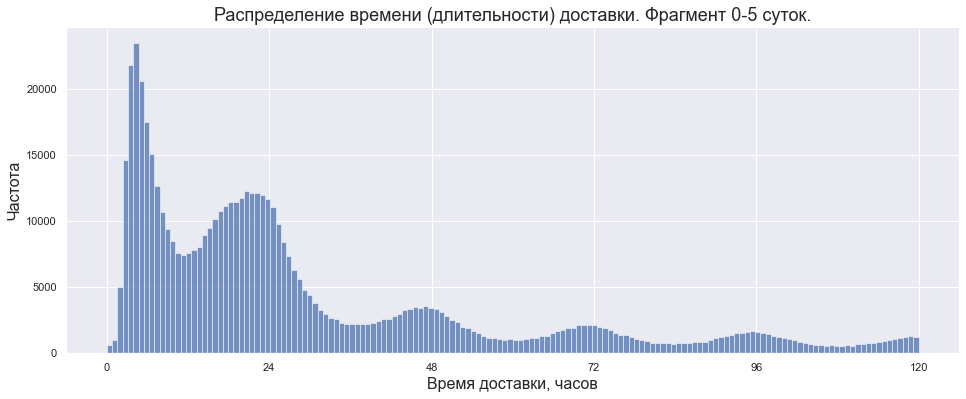

In [50]:
fig, ax = plt.subplots()
sns.histplot(orders_merged.query('delivery_time_h<120 & delivery_time_h>0')['delivery_time_h'])
ax.set_xticks([0, 24, 48, 72, 96, 120])
plt.title('Распределение времени (длительности) доставки. Фрагмент 0-5 суток.', fontsize=18) 
plt.ylabel('Частота', fontsize=16)
plt.xlabel('Время доставки, часов', fontsize=16);

In [51]:
_1day_deliv = len(orders_merged.query('delivery_time_h<24').index)
print('доставлено в течении суток:', _1day_deliv, '({:.2%})'.format(_1day_deliv/len(orders.index)))

доставлено в течении суток: 342109 (47.49%)


* Почти половина заказов доставлена в течении суток. Волнообразность распределения связана с кратностью срока доставки суткам (заказ и доставка примерно в одно время суток).

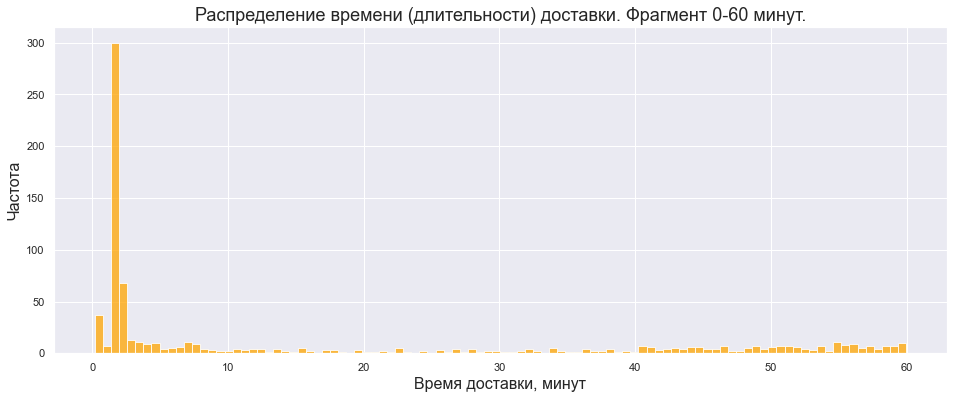

In [52]:
fig, ax = plt.subplots()
sns.histplot(orders_merged.query('delivery_time_h<1 & delivery_time_h>0')['delivery_time_h']*60,bins=100,color='orange')
plt.title('Распределение времени (длительности) доставки. Фрагмент 0-60 минут.', fontsize=18) 
plt.ylabel('Частота', fontsize=16)
plt.xlabel('Время доставки, минут', fontsize=16);

* **высокая плотность доставок со сроком около 2 минут. Какой-то особенный механизм доставки (технические/внутренние/задним числом?)**. 

In [53]:
#orders_merged.query('delivery_time_h<2.5/60 & delivery_time_h>1.5/60')

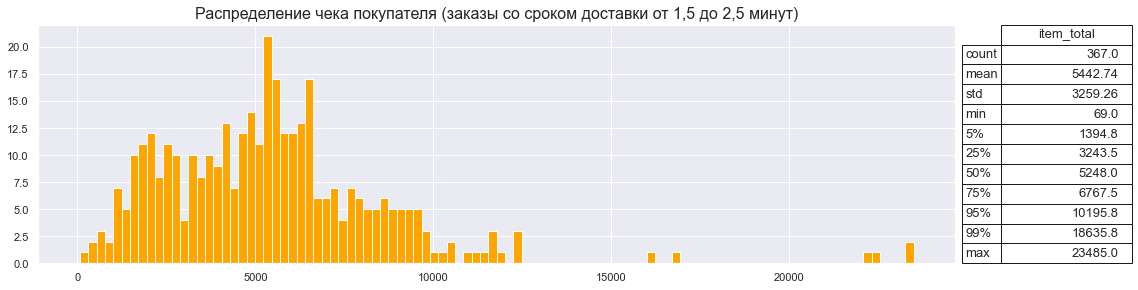

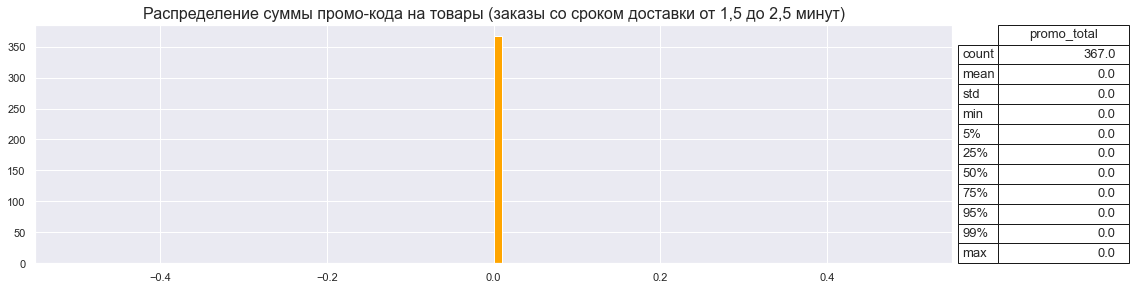

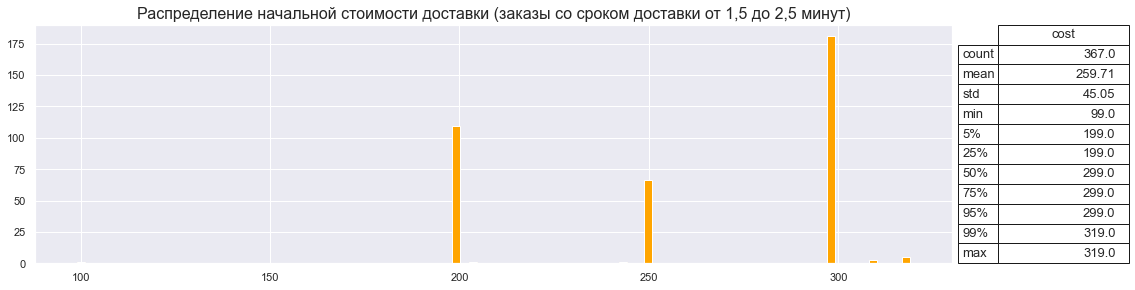

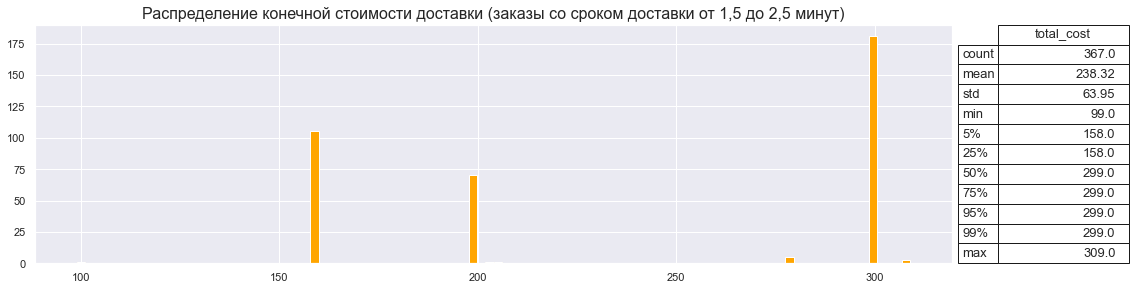

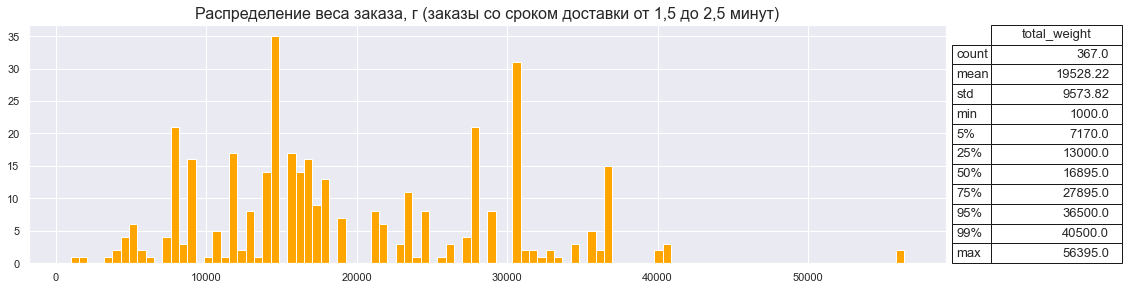

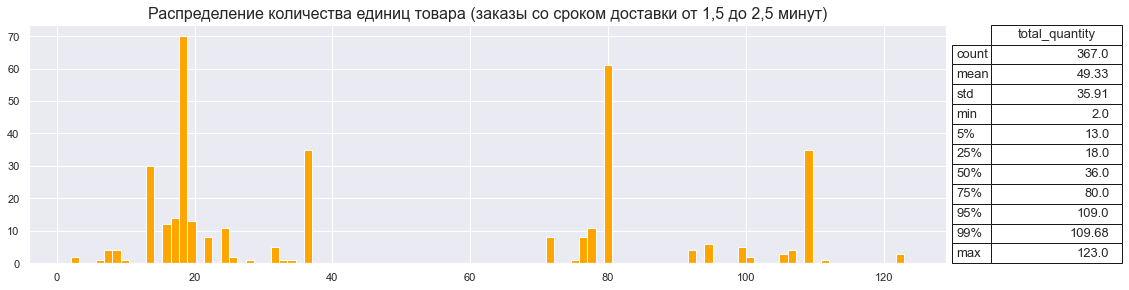

In [54]:
col_list = ['item_total', 'promo_total',  'cost', 'total_cost', 'total_weight', 'total_quantity']
col_name_list = ['чека покупателя', 'суммы промо-кода на товары', 'начальной стоимости доставки', 
                 'конечной стоимости доставки', 'веса заказа, г', 'количества единиц товара']
for i in range (len(col_list)):
    ser = orders_merged.query('delivery_time_h<2.5/60 & delivery_time_h>1.5/60')[col_list[i]]
    
    fig, ax = plt.subplots(1, 2, gridspec_kw={'width_ratios': [7, 1]}, figsize=(16,4))
    fig.tight_layout()
    
    ax[0].hist(ser, bins=100, color='orange') #, range=[ser.quantile(0.01), ser.quantile(0.99)]
    ax[0].set_title('Распределение '+col_name_list[i]+' (заказы со сроком доставки от 1,5 до 2,5 минут)', fontsize=16)
    
    dfxx = ser.describe(percentiles =[.05, .25, .50, .75, .95, .99]).to_frame().round(2)
    ax[1].axis('off')
    mpl_table = ax[1].table(cellText = dfxx.values, rowLabels = dfxx.index, bbox=[0, 0, 1, 1], colLabels=dfxx.columns)
    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(13)

In [55]:
orders_merged

id  user_id  total_cost   cost  item_total  promo_total  \
0        756927   139676         0.0    0.0        5015          0.0   
1        756963   139682         0.0    0.0        7096          0.0   
2        756983    63967       299.0  299.0        2724       -250.0   
3        756985   139687         0.0    0.0        3471          0.0   
4        757066   119006       299.0  299.0        1254          0.0   
...         ...      ...         ...    ...         ...          ...   
720378  5423310  1676786       258.0  258.0        4777          0.0   
720379  5423488  1832586        98.0  238.0        1864          0.0   
720380  5424466  1318477       158.0  238.0        2769       -200.0   
720381  5426016  1116106       158.0  238.0        2876          0.0   
720382  5426868  1389756       158.0  238.0        4376          0.0   

        total_weight  total_quantity    state          shipped_at  \
0              37708              39  shipped 2018-08-26 15:01:42   
1              49435              71  shipped 2018-08-26 16:28:41   
2              11590              32  shipped 2018-08-26 15:09:11   
3               9915              13  shipped 2018-08-26 18:57:01   
4              15022              24  shipped 2018-08-26 13:46:48   
...              ...             ...      ...                 ...   
720378         43286              71  shipped 2019-12-18 15:45:12   
720379          4245              13  shipped 2019-12-18 12:44:16   
720380          4780               7  shipped 2019-12-18 13:16:08   
720381         13385              34  shipped 2019-12-18 14:28:56   
720382         16733              35  shipped 2019-12-18 13:19:32   

                created_at  ship_address_id  store_id  delivery_window_id  \
0      2018-08-26 02:06:55           888330         1              226459   
1      2018-08-26 05:43:20           888394         1              226460   
2      2018-08-26 06:12:13           888420         1              226459   
3      2018-08-26 06:13:59           888422         1              226462   
4      2018-08-26 07:40:58           870688         1              226458   
...                    ...              ...       ...                 ...   
720378 2019-12-18 09:16:28          6346125       235              973254   
720379 2019-12-18 09:20:18          7120759       235              973253   
720380 2019-12-18 09:41:28          6881231       235              973252   
720381 2019-12-18 10:18:37          5606095       235              973254   
720382 2019-12-18 10:36:52          6661630       235              973254   

                 starts_at             ends_at      time_zone  city  \
0      2018-08-26 14:00:00 2018-08-26 16:00:00  Europe/Moscow     1   
1      2018-08-26 15:00:00 2018-08-26 17:00:00  Europe/Moscow     1   
2      2018-08-26 14:00:00 2018-08-26 16:00:00  Europe/Moscow     1   
3      2018-08-26 17:00:00 2018-08-26 19:00:00  Europe/Moscow     1   
4      2018-08-26 13:00:00 2018-08-26 15:00:00  Europe/Moscow     1   
...                    ...                 ...            ...   ...   
720378 2019-12-18 14:00:00 2019-12-18 16:00:00      Asia/Omsk    13   
720379 2019-12-18 13:00:00 2019-12-18 15:00:00      Asia/Omsk    13   
720380 2019-12-18 12:00:00 2019-12-18 14:00:00      Asia/Omsk    13   
720381 2019-12-18 14:00:00 2019-12-18 16:00:00      Asia/Omsk    13   
720382 2019-12-18 14:00:00 2019-12-18 16:00:00      Asia/Omsk    13   

        retailer_id        lat        lon   elevator floor city_name  \
0                 1  55.855683  37.644165       None     3    Moscow   
1                 1  55.858791  37.638656  passenger     8    Moscow   
2                 1  55.890288  37.612822  passenger     3    Moscow   
3                 1  55.878475  37.620050       None     4    Moscow   
4                 1  55.825067  37.621798       None     3    Moscow   
...             ...        ...        ...        ...   ...       ...   
720378           15  55.023707  73.42

In [56]:
#как выглядят заказы с разными сроками доставки
_dict={}
_day = [0, 1, 3, 7, 14, 30, 60, 90, 180, 365, 1000]
for i in range(len(_day)-1):
    b={}
    _df = orders_merged[orders_merged['delivery_time_h']>_day[i]*24]#строки со сроком выполнения доставки больше _day
    _df = _df[_df['delivery_time_h']<=_day[i+1]*24]
    b['ord_count'] = len(_df.index)
    b['ord_%'] = b['ord_count']/720430*100
#    b['user_count'] = _df['user_id'].nunique() 
    b['item_mean'] = _df['item_total'].mean()
    b['total_cost_mean'] = _df['total_cost'].mean()
#    b['cost_mean'] = _df['cost'].mean()
    b['promo_total_mean'] = _df['promo_total'].mean()
    b['total_weight_mean'] = _df['total_weight'].mean()
    b['total_quantity_mean'] = _df['total_quantity'].mean()
    b['in_time_%'] = (_df['deliv_late_h']==0).mean()
    
    _dict[str(_day[i])+'-'+str(_day[i+1])+' дней'] = b
_table = pd.DataFrame(_dict).T

_table.style.format('{:.2f}').bar(subset=['ord_count', 'item_mean', 'total_cost_mean', 'promo_total_mean', 
                                          'total_weight_mean', 'total_quantity_mean', 'in_time_%'], 
                                       align='mid', color=['skyblue', 'Chartreuse'], width=99).set_caption(
    'Сводная таблица заказов с разными сроками доставки')

In [57]:
len(orders_merged[orders_merged['delivery_time_h']>90*24].index)/len(orders_merged.index)

0.005194459058584114

**Промежуточные выводы:**
* высокая плотность доставок со сроком около 2 минут. Какой-то особенный механизм доставки (технические/внутренние/задним числом?).
* 3 заказа доставлены раньше чем заказаны (id = 980548, 980564, 980590)
* есть заказы со сроком доставки > 90 дней (в т.ч. 6-12 месяцев) - выбросы?
* для доставок со сроком 3-14 дней выше средний чек и финальная стоимость доставки (ниже/реже промо)? проверить!

#### Магазины и ритейлеры

14     57606
2      52511
12     47574
8      45599
1      44557
       ...  
259      228
248      221
254      193
317        3
179        1
Name: store_id, Length: 71, dtype: int64


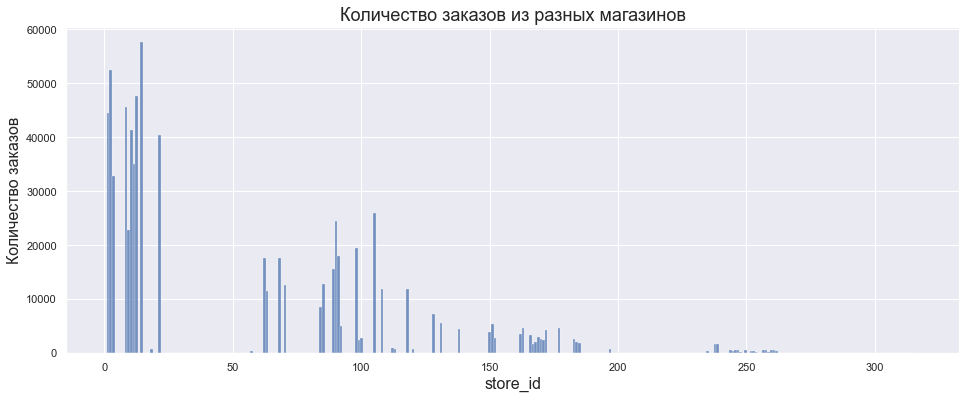

In [58]:
sns.histplot(orders['store_id'], bins=317)
plt.title('Количество заказов из разных магазинов', fontsize=18) 
plt.ylabel('Количество заказов', fontsize=16)
plt.xlabel('store_id', fontsize=16);
print(orders['store_id'].value_counts()) #normalize = True

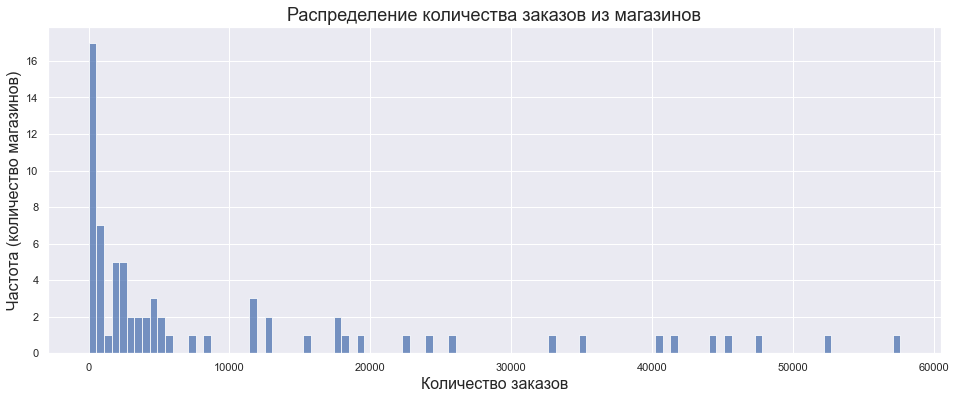

In [59]:
sns.histplot(orders['store_id'].value_counts(), bins=106)
plt.title('Распределение количества заказов из магазинов', fontsize=18) 
plt.ylabel('Частота (количество магазинов)', fontsize=16)
plt.xlabel('Количество заказов', fontsize=16);

In [60]:
#группировка по store_id
store_orders = orders.pivot_table(index=['store_id'], aggfunc={'cost': 'mean', 
                                                             'created_at': ('count', max, min),
                                                             'item_total': ('mean', sum),
                                                             'total_cost': 'mean',
                                                             'total_quantity': 'mean',
                                                             'total_weight': 'mean',
                                                             'user_id': pd.Series.nunique})
store_orders.set_axis(['s_cost_mean', 's_order_count', 's_last_order_at', 's_first_order_at', 
                      's_item_mean', 's_item_sum', 's_total_cost_mean', 's_quantity_mean', 
                      's_weight_mean', 's_user_count'], axis='columns', inplace=True)
display(store_orders.head(3))

s_cost_mean  s_order_count     s_last_order_at    s_first_order_at  \
store_id                                                                       
1          290.690995          44557 2019-12-18 17:23:26 2018-08-26 02:06:55   
2          290.012227          52511 2019-12-18 16:59:03 2018-08-26 05:53:16   
3          284.848890          32806 2019-12-18 15:05:56 2018-08-26 03:46:09   

          s_item_mean   s_item_sum  s_total_cost_mean  s_quantity_mean  \
store_id                                                                 
1         5703.695693  254139569.0         201.902454        49.753776   
2         5604.142008  294279101.0         204.704272        48.538554   
3         4910.504938  161094025.0         193.487219        42.812870   

          s_weight_mean  s_user_count  
store_id                               
1          28603.773100         17202  
2          29462.463541         19378  
3          26046.807413         13518

<ipython-input-61-1af931ac1091>:13: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  dfxx = ser.describe(percentiles =[.05, .25, .50, .75, .95, .99]).to_frame().round(2)


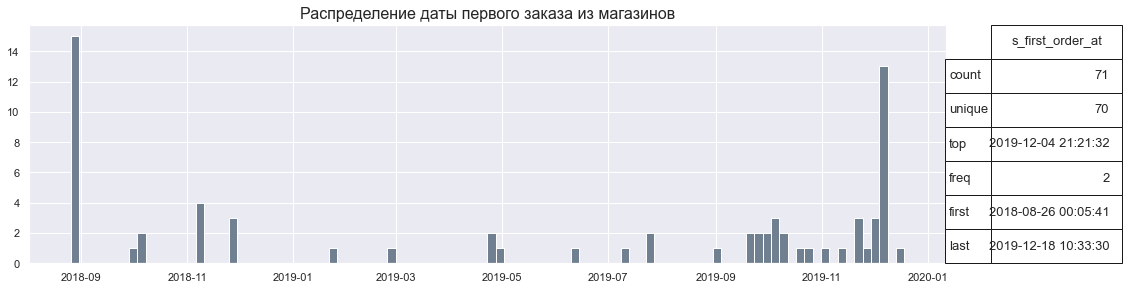

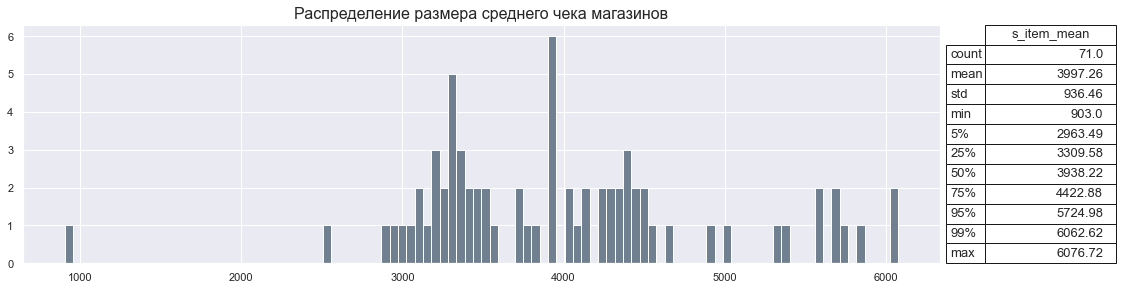

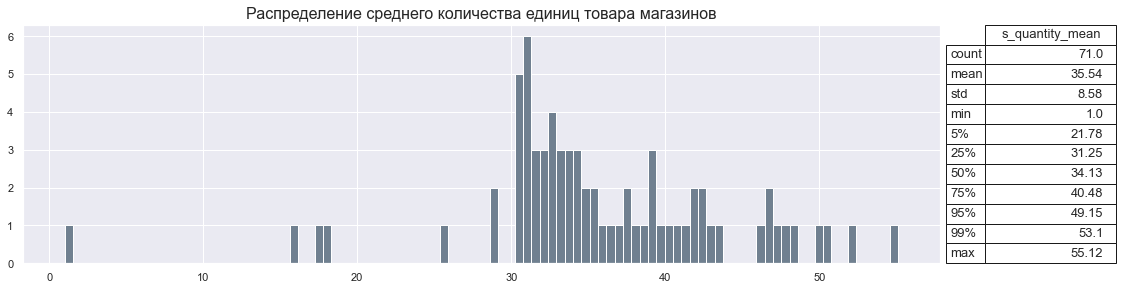

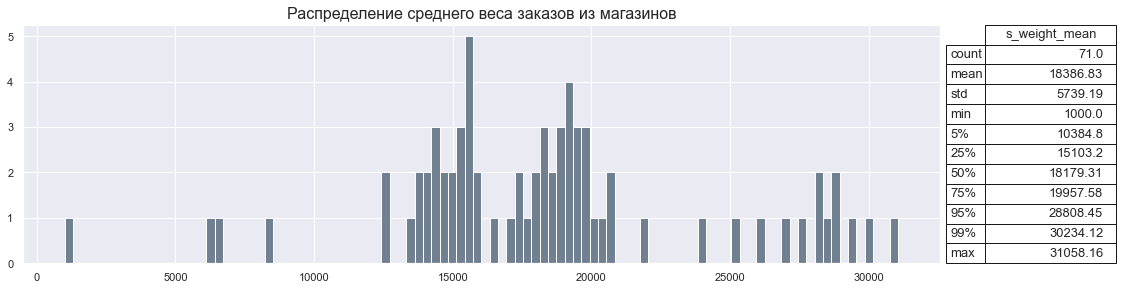

In [61]:
col_list = ['s_first_order_at', 's_item_mean', 's_quantity_mean', 's_weight_mean']
col_name_list = ['даты первого заказа из', 'размера среднего чека', 'среднего количества единиц товара', 
                 'среднего веса заказов из']
for i in range (len(col_list)):
    ser = store_orders[col_list[i]] #столбец из df
    
    fig, ax = plt.subplots(1, 2, gridspec_kw={'width_ratios': [7, 1]}, figsize=(16,4))
    fig.tight_layout()
    
    ax[0].hist(ser, bins=100, color='slategrey') #, range=[ser.min(), ser.quantile(0.99)])
    ax[0].set_title('Распределение ' + col_name_list[i] + ' магазинов', fontsize=16) 
    
    dfxx = ser.describe(percentiles =[.05, .25, .50, .75, .95, .99]).to_frame().round(2)
    ax[1].axis('off')
    mpl_table = ax[1].table(cellText = dfxx.values, rowLabels = dfxx.index, bbox=[0, 0, 1, 1], colLabels=dfxx.columns)
    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(13)

In [62]:
print('Магазины со сроком доставки менее 5 минут:', 
      orders_merged.query('delivery_time_h<5/60 & delivery_time_h>0/60')['store_id'].unique().tolist())
print('Покупатели со сроком доставки от 1,5 до 2,5 минут:',
      orders_merged.query('delivery_time_h<2.5/60 & delivery_time_h>1.5/60')['user_id'].unique().tolist())

Магазины со сроком доставки менее 5 минут: [8, 12, 14, 18, 70]
Покупатели со сроком доставки от 1,5 до 2,5 минут: [42319, 215536, 361973, 1635243]


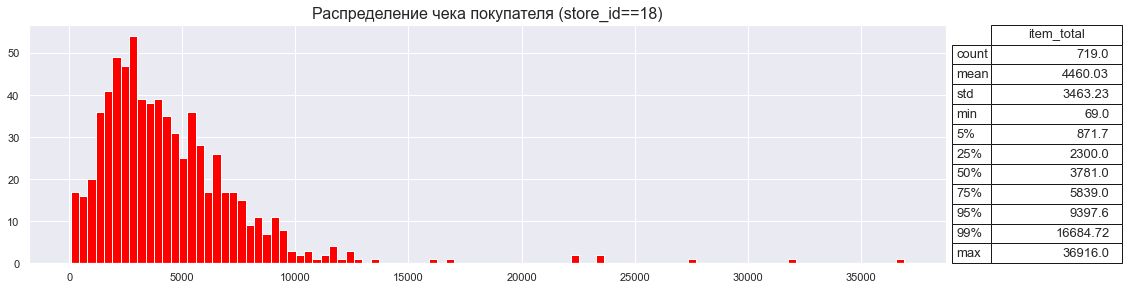

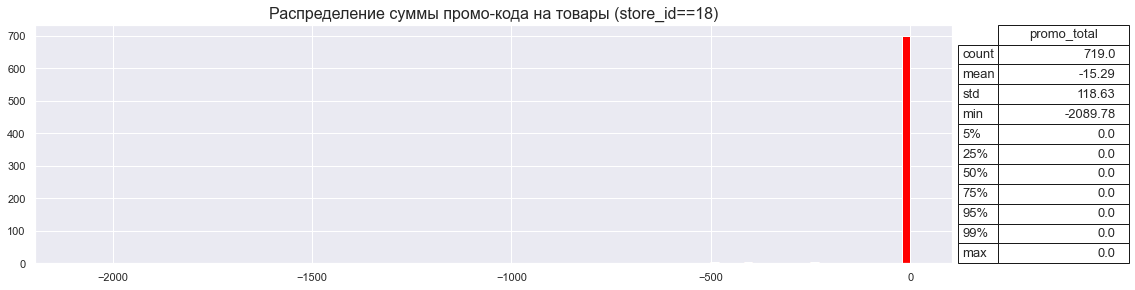

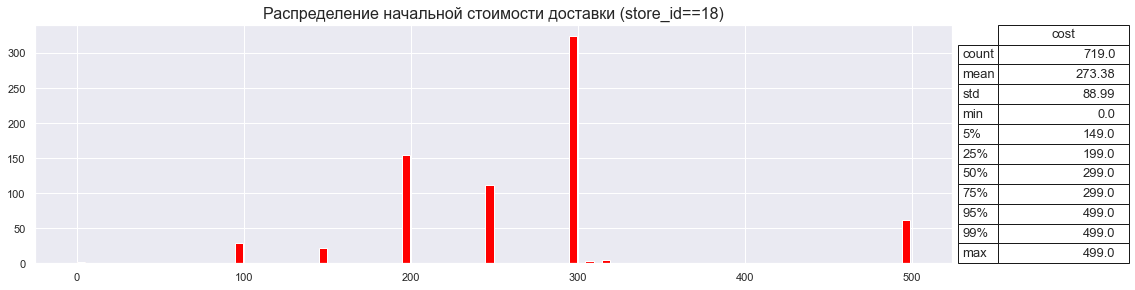

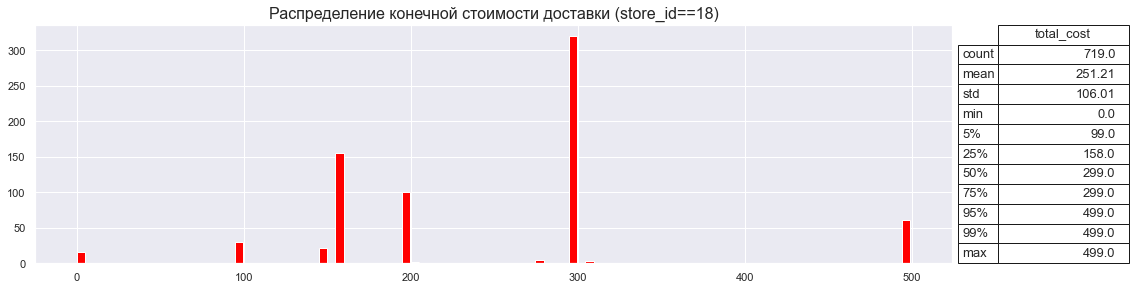

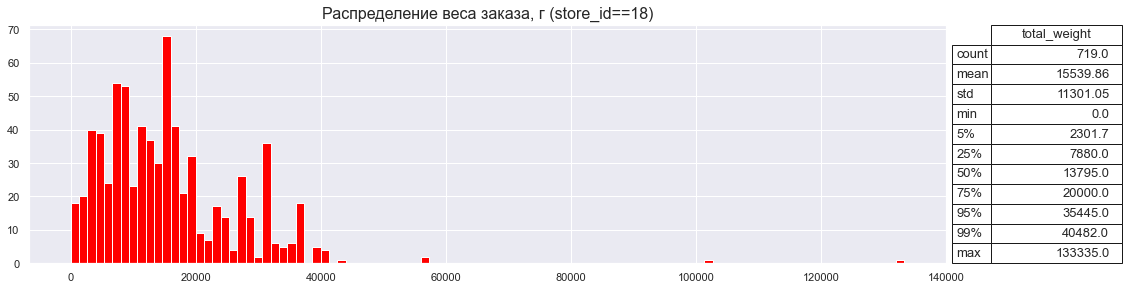

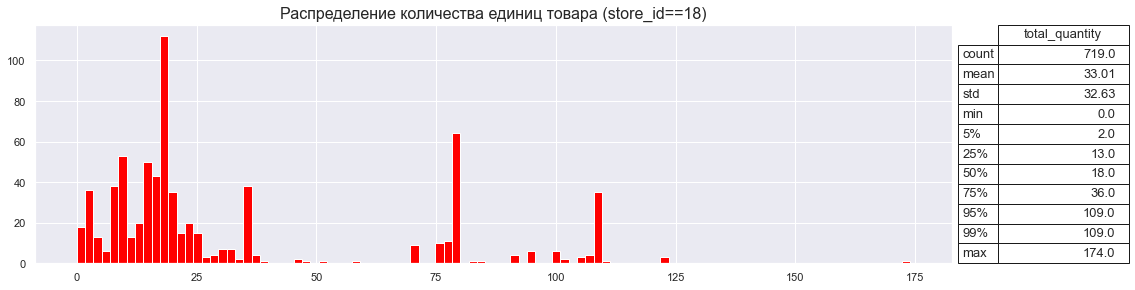

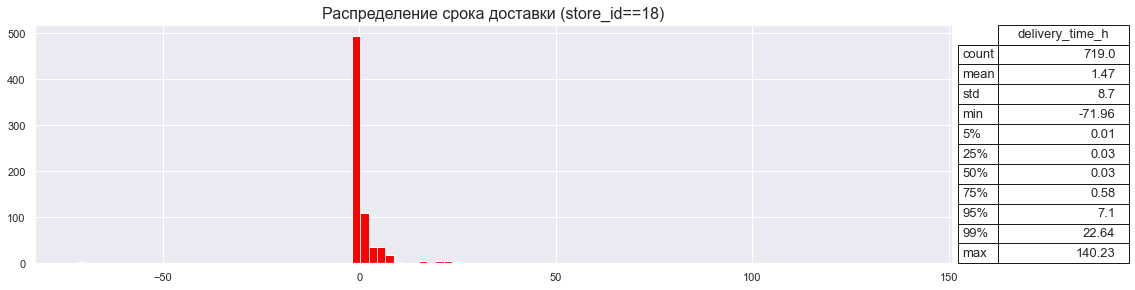

In [63]:
#посмотрю на store_id==18 повнимательнее
col_list = ['item_total', 'promo_total',  'cost', 'total_cost', 'total_weight', 'total_quantity', 'delivery_time_h']
col_name_list = ['чека покупателя', 'суммы промо-кода на товары', 'начальной стоимости доставки', 
                 'конечной стоимости доставки', 'веса заказа, г', 'количества единиц товара', 'срока доставки']
for i in range (len(col_list)):
    ser = orders_merged.query('store_id==18')[col_list[i]]
    
    fig, ax = plt.subplots(1, 2, gridspec_kw={'width_ratios': [7, 1]}, figsize=(16,4))
    fig.tight_layout()
    
    ax[0].hist(ser, bins=100, color='red') #, range=[ser.quantile(0.01), ser.quantile(0.99)]
    ax[0].set_title('Распределение '+col_name_list[i]+' (store_id==18)', fontsize=16)
    
    dfxx = ser.describe(percentiles =[.05, .25, .50, .75, .95, .99]).to_frame().round(2)
    ax[1].axis('off')
    mpl_table = ax[1].table(cellText = dfxx.values, rowLabels = dfxx.index, bbox=[0, 0, 1, 1], colLabels=dfxx.columns)
    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(13)

In [64]:
orders_merged

id  user_id  total_cost   cost  item_total  promo_total  \
0        756927   139676         0.0    0.0        5015          0.0   
1        756963   139682         0.0    0.0        7096          0.0   
2        756983    63967       299.0  299.0        2724       -250.0   
3        756985   139687         0.0    0.0        3471          0.0   
4        757066   119006       299.0  299.0        1254          0.0   
...         ...      ...         ...    ...         ...          ...   
720378  5423310  1676786       258.0  258.0        4777          0.0   
720379  5423488  1832586        98.0  238.0        1864          0.0   
720380  5424466  1318477       158.0  238.0        2769       -200.0   
720381  5426016  1116106       158.0  238.0        2876          0.0   
720382  5426868  1389756       158.0  238.0        4376          0.0   

        total_weight  total_quantity    state          shipped_at  \
0              37708              39  shipped 2018-08-26 15:01:42   
1              49435              71  shipped 2018-08-26 16:28:41   
2              11590              32  shipped 2018-08-26 15:09:11   
3               9915              13  shipped 2018-08-26 18:57:01   
4              15022              24  shipped 2018-08-26 13:46:48   
...              ...             ...      ...                 ...   
720378         43286              71  shipped 2019-12-18 15:45:12   
720379          4245              13  shipped 2019-12-18 12:44:16   
720380          4780               7  shipped 2019-12-18 13:16:08   
720381         13385              34  shipped 2019-12-18 14:28:56   
720382         16733              35  shipped 2019-12-18 13:19:32   

                created_at  ship_address_id  store_id  delivery_window_id  \
0      2018-08-26 02:06:55           888330         1              226459   
1      2018-08-26 05:43:20           888394         1              226460   
2      2018-08-26 06:12:13           888420         1              226459   
3      2018-08-26 06:13:59           888422         1              226462   
4      2018-08-26 07:40:58           870688         1              226458   
...                    ...              ...       ...                 ...   
720378 2019-12-18 09:16:28          6346125       235              973254   
720379 2019-12-18 09:20:18          7120759       235              973253   
720380 2019-12-18 09:41:28          6881231       235              973252   
720381 2019-12-18 10:18:37          5606095       235              973254   
720382 2019-12-18 10:36:52          6661630       235              973254   

                 starts_at             ends_at      time_zone  city  \
0      2018-08-26 14:00:00 2018-08-26 16:00:00  Europe/Moscow     1   
1      2018-08-26 15:00:00 2018-08-26 17:00:00  Europe/Moscow     1   
2      2018-08-26 14:00:00 2018-08-26 16:00:00  Europe/Moscow     1   
3      2018-08-26 17:00:00 2018-08-26 19:00:00  Europe/Moscow     1   
4      2018-08-26 13:00:00 2018-08-26 15:00:00  Europe/Moscow     1   
...                    ...                 ...            ...   ...   
720378 2019-12-18 14:00:00 2019-12-18 16:00:00      Asia/Omsk    13   
720379 2019-12-18 13:00:00 2019-12-18 15:00:00      Asia/Omsk    13   
720380 2019-12-18 12:00:00 2019-12-18 14:00:00      Asia/Omsk    13   
720381 2019-12-18 14:00:00 2019-12-18 16:00:00      Asia/Omsk    13   
720382 2019-12-18 14:00:00 2019-12-18 16:00:00      Asia/Omsk    13   

        retailer_id        lat        lon   elevator floor city_name  \
0                 1  55.855683  37.644165       None     3    Moscow   
1                 1  55.858791  37.638656  passenger     8    Moscow   
2                 1  55.890288  37.612822  passenger     3    Moscow   
3                 1  55.878475  37.620050       None     4    Moscow   
4                 1  55.825067  37.621798       None     3    Moscow   
...             ...        ...        ...        ...   ...       ...   
720378           15  55.023707  73.42

In [65]:
#orders_merged.groupby(['store_id'])['city'].nunique()

Каждый магазин соответствует 1 городу.

In [66]:
#заказы по ритейлеру
_dict={}
for _ret in [1, 8, 15, 16]:
    b={}
    _df = orders_merged[orders_merged['retailer_id']==_ret]
    b['ord_count'] = len(_df.index)
    b['ord_ratio'] = b['ord_count']/720430*100
    b['item_mean'] = _df['item_total'].mean()
    b['total_cost_mean'] = _df['total_cost'].mean()
    b['promo_total_mean'] = _df['promo_total'].mean()
    b['total_quantity_mean'] = _df['total_quantity'].mean()
    b['delivery_time_h_mean'] =_df['delivery_time_h'].mean()
    b['in_time_%'] = (_df['deliv_late_h']==0).mean()
    _dict[_ret] = b
 
_table = pd.DataFrame(_dict).T

_table.style.format('{:.2f}').bar(subset=['ord_count', 'total_cost_mean', 'item_mean', 'promo_total_mean', 
                                          'total_quantity_mean', 'delivery_time_h_mean', 'in_time_%'], 
                                       align='mid', color=['skyblue', 'Chartreuse'], width=98).set_caption(
    'Сводная таблица заказов по ритейлеру')

* в срез попали 71 магазин и 4 ритейлера (в stores - 162 магазина и 6 ритейлеров)
* есть особенности доставки из магазинов (store_id [ 8, 12, 14, 18, 70], особое внимание 18) - встречаются крайне низкие сроки доставки
* также необычное поведение у user_id=215536 - 405 заказов из store_id=18

#### Даты

In [67]:
print('минимальная дата заказа', orders['created_at'].min())
print('максимальная дата заказа', orders['created_at'].max())
print('максимальная дата доставки', orders['shipped_at'].max())

минимальная дата заказа 2018-08-26 00:05:41
максимальная дата заказа 2019-12-18 18:02:41
максимальная дата доставки 2019-12-18 23:47:42


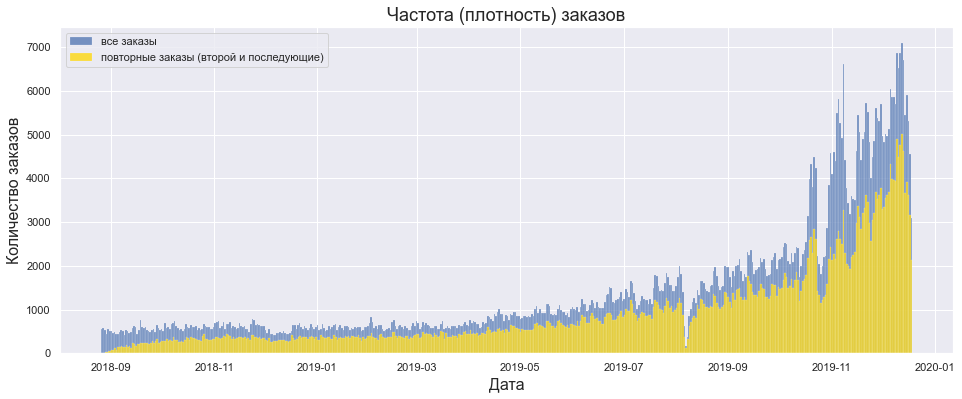

In [68]:
sns.histplot(orders_merged['created_at'], bins=500)
sns.histplot(orders_merged.query('buy_num>1')['created_at'], color='gold', bins=500)
plt.legend(labels=['все заказы', 'повторные заказы (второй и последующие)'])
plt.title('Частота (плотность) заказов', fontsize=18) 
plt.ylabel('Количество заказов', fontsize=16)
plt.xlabel('Дата', fontsize=16);

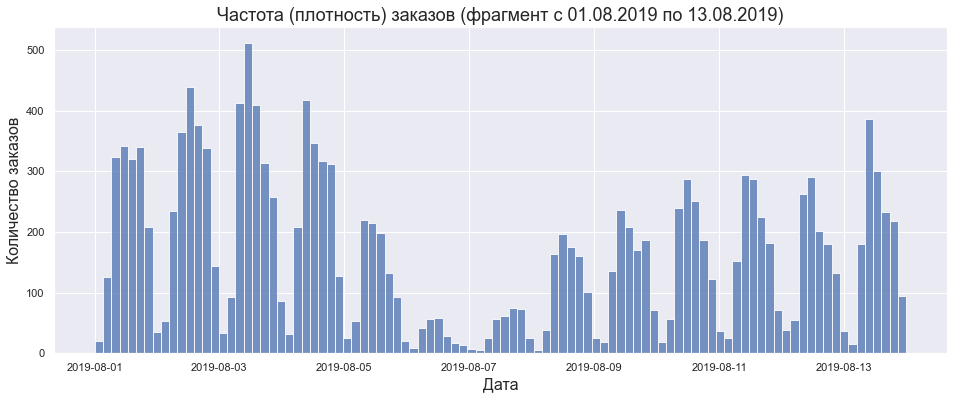

In [69]:
sns.histplot(orders.query('created_at>"2019-08-01" & created_at<"2019-08-14"')['created_at'], bins=98)
plt.title('Частота (плотность) заказов (фрагмент с 01.08.2019 по 13.08.2019)', fontsize=18) 
plt.ylabel('Количество заказов', fontsize=16)
plt.xlabel('Дата', fontsize=16);

Провал 06-07 августа 2019. Причины - ?  

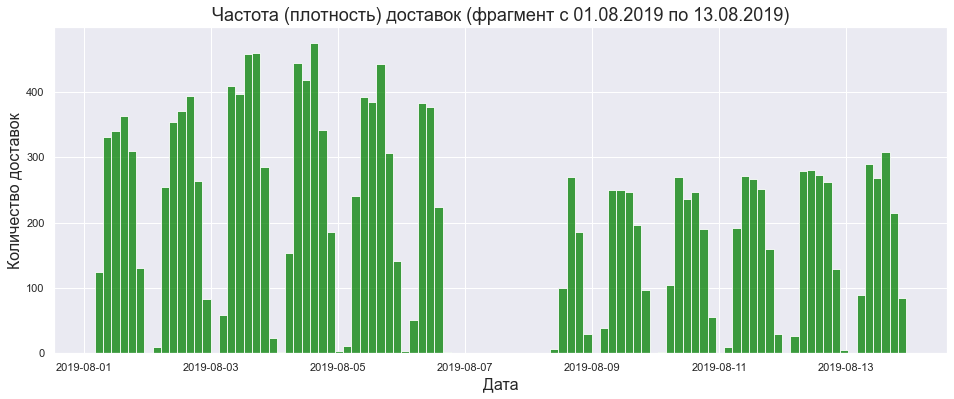

In [70]:
sns.histplot(orders.query('shipped_at>"2019-08-01" & shipped_at<"2019-08-14"')['shipped_at'], bins=98, color='green')
plt.title('Частота (плотность) доставок (фрагмент с 01.08.2019 по 13.08.2019)', fontsize=18) 
plt.ylabel('Количество доставок', fontsize=16)
plt.xlabel('Дата', fontsize=16);

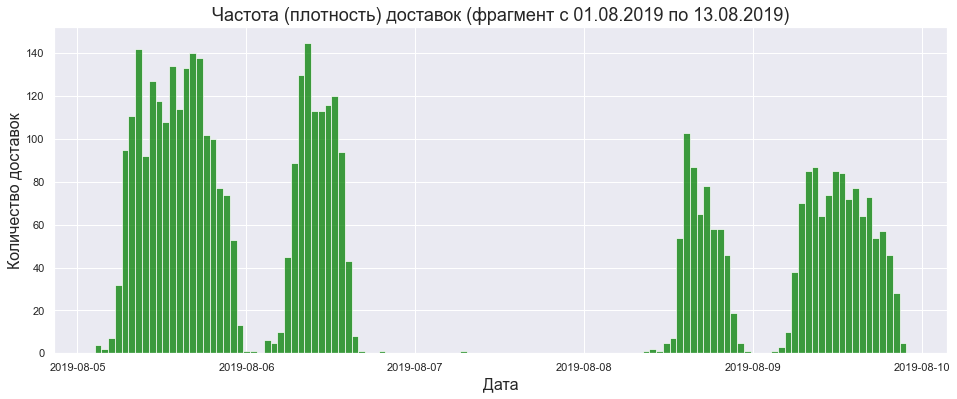

In [71]:
sns.histplot(orders.query('shipped_at>"2019-08-05 0:00:00" & shipped_at<"2019-08-10 0:00:00"')['shipped_at'], 
             color='green', bins=120)
plt.title('Частота (плотность) доставок (фрагмент с 01.08.2019 по 13.08.2019)', fontsize=18) 
plt.ylabel('Количество доставок', fontsize=16)
plt.xlabel('Дата', fontsize=16);

In [72]:
display(orders.query('shipped_at>"2019-08-06 14:59:26" & shipped_at<"2019-08-08 11:15:30"').sort_values(
    'shipped_at').head(15))

id  user_id  total_cost   cost  item_total  promo_total  \
606351  1932680   337682         0.0  229.0        3549         0.00   
19495   1890860   387252         0.0    0.0        7837      -491.89   
216010  1938389   688442        98.0  249.0        1343         0.00   
519655  1157500   685492        98.0  238.0        3742         0.00   
521628  1926317   200135       158.0  238.0         958         0.00   
216017  1939434   688886        98.0  249.0        2487      -399.00   
256118  1940793   689964        98.0  249.0        1300         0.00   
403626  1935654   276479       161.0  161.0       10002         0.00   
380527  1942370   215536       158.0  199.0        5031         0.00   
151091  1933876   357000       249.0  249.0        5940         0.00   
704033  1927833   681884        98.0  128.0        6646      -250.00   
704003  1921617   294506       180.0  180.0        5679         0.00   
704054  1942859   294506       158.0  238.0        2669         0.00   
703732  1877403   270411        99.0   99.0        3151      -500.00   
704028  1926681   661813       158.0  238.0        2555      -299.00   

        total_weight  total_quantity    state          shipped_at  \
606351         19120              32  shipped 2019-08-06 15:08:14   
19495          36793              70  shipped 2019-08-06 15:14:22   
216010         10904              34  shipped 2019-08-06 15:17:38   
519655          7825              13  shipped 2019-08-06 15:18:42   
521628         19230              67  shipped 2019-08-06 15:23:21   
216017          3100               3  shipped 2019-08-06 15:35:36   
256118          4625               7  shipped 2019-08-06 15:55:15   
403626         59720              64  shipped 2019-08-06 19:37:10   
380527         35895              94  shipped 2019-08-07 07:04:06   
151091          9565              26  shipped 2019-08-08 08:39:29   
704033         28670              71  shipped 2019-08-08 09:49:25   
704003         42750              51  shipped 2019-08-08 10:08:01   
704054         29800              41  shipped 2019-08-08 10:11:08   
703732         11176              38  shipped 2019-08-08 11:10:25   
704028          7920              31  shipped 2019-08-08 11:13:30   

                created_at  ship_address_id  store_id  delivery_window_id  
606351 2019-08-05 05:02:04          2083868       128              642329  
19495  2019-07-31 21:36:29          2609918         1              640587  
216010 2019-08-05 16:32:20          2682176        10              640724  
519655 2019-02-23 19:20:54          1548383        84              641613  
521628 2019-08-04 13:13:56          2566183        84              641613  
216017 2019-08-05 19:30:49          2683511        10              640724  
256118 2019-08-06 07:15:34          2683925        11              640749  
403626 2019-08-05 10:46:10          2613495        21              640914  
380527 2019-08-07 07:02:23          2688090        18              642679  
151091 2019-08-05 07:51:15          2481684         8              640665  
704033 2019-08-04 15:22:13          2667588       108              645580  
704003 2019-08-04 05:40:38          2505280       108              645580  
704054 2019-08-07 11:21:10          2674294       108              645581  
703732 2019-07-30 09:54:53          2561116       108              645581  
704028 2019-08-04 13:45:14          2622381       108              645581

**Провал вероятно вызван проблемами с доставкой. Т.к. в рассматриваемый период (с 16:00 06.08.2019 до 08:30 08.08.2019 т.е. более 40 часов) заказы на будущие даты оформлены и исполнены, а доставки не регистрировались.**  

* два заказа (id 1935654 и 1942370) всё же доставлены. у второго (user_id = 215536) доставка "закрыта" через 2 минуты после заказа - посмотреть внимательнее!!! 


In [73]:
orders.query('user_id==215536')

id  user_id  total_cost   cost  item_total  promo_total  \
380045  1027706   215536       149.0  149.0        1971          0.0   
380046  1027714   215536       149.0  149.0        4284          0.0   
380047  1028552   215536       199.0  199.0        3079          0.0   
380049  1030465   215536       199.0  199.0        4285          0.0   
380050  1030597   215536       199.0  199.0        1880          0.0   
...         ...      ...         ...    ...         ...          ...   
380695  5260382   215536       199.0  199.0        7788          0.0   
380696  5295632   215536       199.0  199.0       11717          0.0   
380697  5338384   215536       199.0  199.0       10499          0.0   
380698  5376399   215536       199.0  199.0        7488          0.0   
380699  5415656   215536       199.0  199.0        6895          0.0   

        total_weight  total_quantity    state          shipped_at  \
380045          9300              18  shipped 2019-01-01 17:04:01   
380046         24300              23  shipped 2019-01-01 17:08:41   
380047         12975              20  shipped 2019-01-02 05:38:04   
380049         12975              20  shipped 2019-01-02 21:03:59   
380050         12900              20  shipped 2019-01-03 04:02:38   
...              ...             ...      ...                 ...   
380695         17150             109  shipped 2019-12-14 06:04:04   
380696         26150             109  shipped 2019-12-15 06:04:02   
380697         26150             109  shipped 2019-12-16 06:05:50   
380698         17150             109  shipped 2019-12-17 06:07:30   
380699         17150             109  shipped 2019-12-18 06:04:02   

                created_at  ship_address_id  store_id  delivery_window_id  
380045 2019-01-01 17:03:39          1348766        18              352627  
380046 2019-01-01 17:08:24          1348785        18              352627  
380047 2019-01-02 05:37:18          1350249        18              353661  
380049 2019-01-02 21:03:26          1353483        18              354897  
380050 2019-01-03 04:01:55          1353689        18              354898  
...                    ...              ...       ...                 ...  
380695 2019-12-14 06:02:14          6917843        18              954979  
380696 2019-12-15 06:02:10          6962257        18              958723  
380697 2019-12-16 06:04:00          7017687        18              962470  
380698 2019-12-17 06:05:43          7065337        18              966214  
380699 2019-12-18 06:02:12          7111984        18              969984  

[405 rows x 14 columns]

In [74]:
#заказы по дням недели
_dict={}
for _day in range(7):
    b={}
    _df = orders_merged[orders_merged['sh_weekday']==_day]
    b['ord_count'] = len(_df.index)
    b['ord_ratio'] = b['ord_count']/720430*100
    b['item_mean'] = _df['item_total'].mean()
    b['total_cost_mean'] = _df['total_cost'].mean()
    b['promo_total_mean'] = _df['promo_total'].mean()
    b['total_quantity_mean'] = _df['total_quantity'].mean()
    b['delivery_time_h_mean'] =_df['delivery_time_h'].mean()
    b['in_time_%'] = (_df['deliv_late_h']==0).mean()   
    _dict[_day] = b
    
_table = pd.DataFrame(_dict).T

_table.style.format('{:.2f}').bar(subset=['ord_count', 'total_cost_mean', 'item_mean', 'promo_total_mean',
                                          'total_quantity_mean', 'delivery_time_h_mean', 'in_time_%'], 
                                       align='mid', color=['skyblue', 'Chartreuse'], width=98).set_caption(
    'Сводная таблица заказов по дням недели (0-пн, 6-вс)')

* средний чек в выходные ниже - проверить гипотезу
* скидки в выходные выше?

In [75]:
#заказы по месяцам
_dict={}
for _ym in sorted(orders_merged['yearmonth'].unique()):
    b={}
    _df = orders_merged[orders_merged['yearmonth']==_ym]
    b['ord_count'] = len(_df.index)
    b['ord_ratio'] = b['ord_count']/720430*100
    b['2ord_%'] = len(_df.query('buy_num==2').index)/b['ord_count'] #доля повторных заказов
    b['item_mean'] = _df['item_total'].mean()  
    b['total_cost_mean'] = _df['total_cost'].mean()
    b['promo_total_mean'] = _df['promo_total'].mean()
    b['total_quantity_mean'] = _df['total_quantity'].mean()
    b['delivery_time_h_mean'] =_df['delivery_time_h'].mean()
    b['in_time_%'] = (_df['deliv_late_h']==0).mean()  
    _dict[str(_ym)] = b
    
_table = pd.DataFrame(_dict).T

_table.style.format('{:.2f}').bar(subset=['ord_count', 'total_cost_mean', 'item_mean', 'promo_total_mean', 
                                          'total_quantity_mean', 'delivery_time_h_mean', 'in_time_%'], 
                                       align='mid', color=['skyblue', 'Chartreuse'], width=98).set_caption(
    'Сводная таблица заказов по месяцам')

**Промежуточные выводы:**
* провал в доставках с 16:00 06.08.2019 до 08:30 08.08.2019 (т.е. более 40 часов). Вероятно вызван проблемами с логистикой т.к. доставки не регистрировались, при этом заказы на будущие даты оформлены и исполнены.
* тренд на снижение срока доставки? (возможно из-за расширения географии)
* средний срок доставки в сентябре 2019 - 77 часов - значительно ниже чем в другие периоды.
* снижение размера заказа (сумма корзины, количество позиций, вес) в августе-сентябре 2019

#### Время и time_zone

In [76]:
print('Всего заказов', len(orders.index))
print('Ожидаю заказов/доставок в 00 минут 00 секунд:', len(orders.index)/60/60)

#заказы созданные в 00 минут 00 секунд
df = orders[(orders['created_at'].dt.minute*60+orders['created_at'].dt.second)==0]
print('Количество заказов созданных в 00 минут 00 секунд:', len(df.index))

df2 = orders[(orders['shipped_at'].dt.minute*60+orders['shipped_at'].dt.second)==0]
print('Количество заказов "доставленных" в 00 минут 00 секунд:', len(df2.index))

df[(df['shipped_at'].dt.minute*60+df['shipped_at'].dt.second)==0]

Всего заказов 720433
Ожидаю заказов/доставок в 00 минут 00 секунд: 200.12027777777777
Количество заказов созданных в 00 минут 00 секунд: 187
Количество заказов "доставленных" в 00 минут 00 секунд: 1802


id  user_id  total_cost   cost  item_total  promo_total  \
58114  1229556   212167       314.0  314.0        3122          0.0   
58790  1261589    47575         0.0  299.0        3905          0.0   

       total_weight  total_quantity    state          shipped_at  \
58114         32888              26  shipped 2019-04-01 08:00:00   
58790          6697              21  shipped 2019-04-05 20:00:00   

               created_at  ship_address_id  store_id  delivery_window_id  
58114 2019-03-24 20:00:00          1628188         2              451673  
58790 2019-04-05 06:00:00           753301         2              456281

* Доставлено в 00 минут 00 секунд в 9 раз больше ожидаемого. Вероятно указывается не фактическое время доставки а примерное (Возможно "подгоняется" под окно доставки - не подтвердилось - см. раздел "Попадание в окно доставки"). 

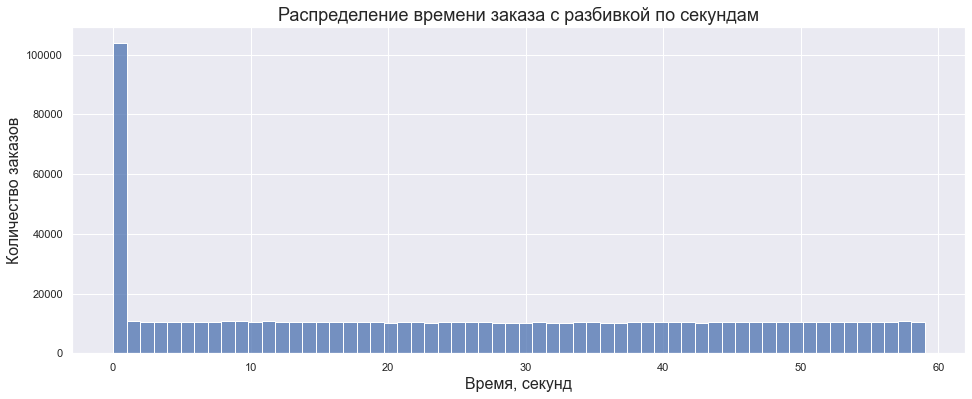

In [77]:
sns.histplot(orders['shipped_at'].dt.second, bins=60)
plt.title('Распределение времени заказа с разбивкой по секундам', fontsize=18) 
plt.ylabel('Количество заказов', fontsize=16)
plt.xlabel('Время, секунд', fontsize=16);

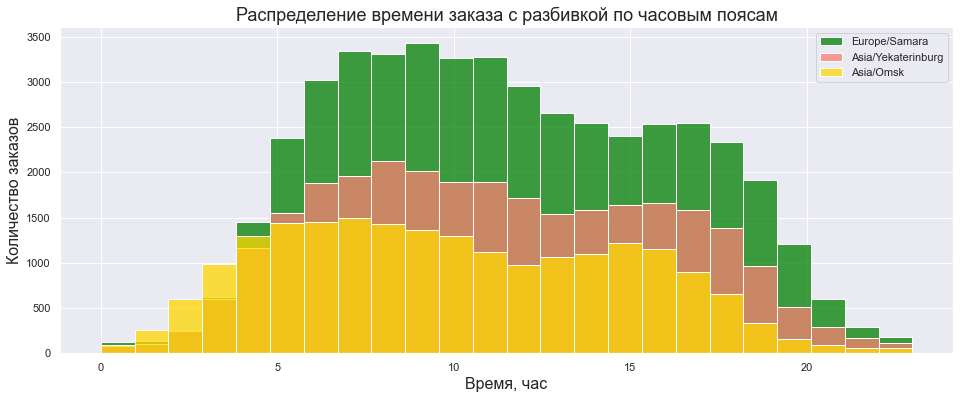

In [78]:
#заказы по времени
#sns.histplot(orders_merged.query('time_zone=="Europe/Moscow"')['created_at'].dt.hour, bins=24)
sns.histplot(orders_merged.query('time_zone=="Europe/Samara"')['created_at'].dt.hour, color='green', bins=24)
sns.histplot(orders_merged.query('time_zone=="Asia/Yekaterinburg"')['created_at'].dt.hour, color='salmon', bins=24)
sns.histplot(orders_merged.query('time_zone=="Asia/Omsk"')['created_at'].dt.hour, color='gold', bins=24)
#sns.histplot(orders_merged.query('time_zone=="Europe/Kaliningrad"')['created_at'].dt.hour, color='red', bins=24)
plt.legend(labels=['Europe/Samara', 'Asia/Yekaterinburg', 'Asia/Omsk'])
plt.title('Распределение времени заказа с разбивкой по часовым поясам', fontsize=18) 
plt.ylabel('Количество заказов', fontsize=16)
plt.xlabel('Время, час', fontsize=16);

In [79]:
for _tz in list(orders_merged['time_zone'].value_counts().index):
    print(_tz)
    print(orders_merged[orders_merged['time_zone']==_tz]['city_name'].value_counts())
    print('-'*30)

Europe/Moscow
Moscow             478798
Rostov-on-Don       76360
Kazan               39692
Nizhny Novgorod     29386
Name: city_name, dtype: int64
------------------------------
Europe/Samara
Samara    46789
Name: city_name, dtype: int64
------------------------------
Asia/Yekaterinburg
Ufa    28677
Name: city_name, dtype: int64
------------------------------
Asia/Omsk
Omsk    20576
Name: city_name, dtype: int64
------------------------------
Europe/Kaliningrad
Kazan     91
Moscow    14
Name: city_name, dtype: int64
------------------------------


* В некоторых случаях (вероятно когда время "закрытия" доставки отмечается вручную) время доставки округляется до целой минуты (00 секунд).

#### Сумма чека

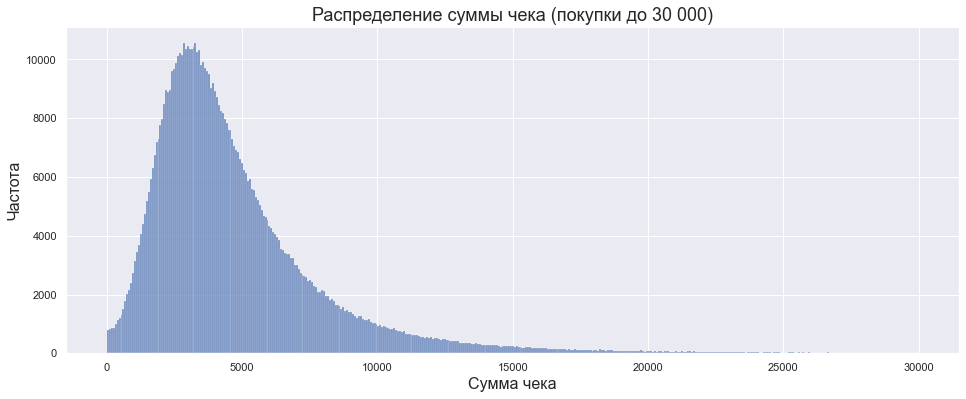

In [80]:
sns.histplot(orders.query('item_total<30000')['item_total'])
plt.title('Распределение суммы чека (покупки до 30 000)', fontsize=18) 
plt.ylabel('Частота', fontsize=16)
plt.xlabel('Сумма чека', fontsize=16);

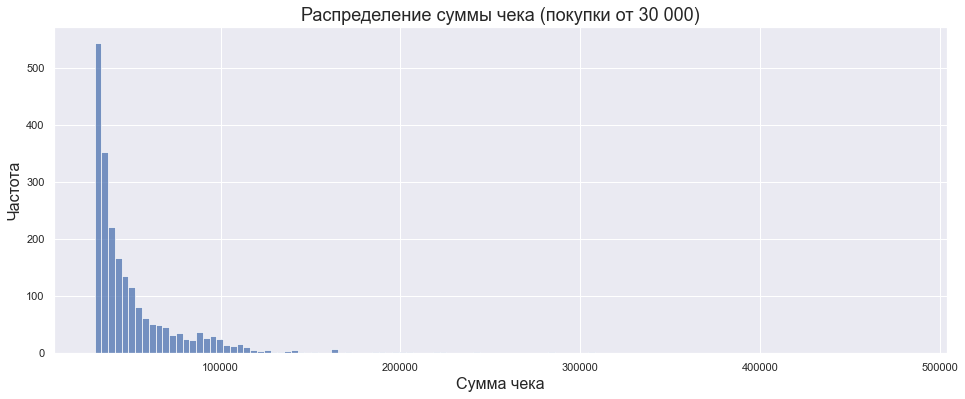

In [81]:
sns.histplot(orders.query('item_total>=30000')['item_total'])
plt.title('Распределение суммы чека (покупки от 30 000)', fontsize=18) 
plt.ylabel('Частота', fontsize=16)
plt.xlabel('Сумма чека', fontsize=16);

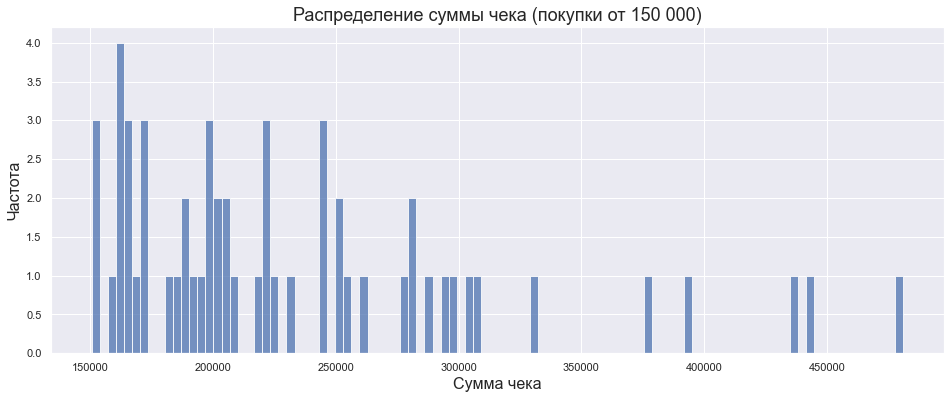

In [82]:
sns.histplot(orders.query('item_total>=150000')['item_total'], bins=100)
plt.title('Распределение суммы чека (покупки от 150 000)', fontsize=18) 
plt.ylabel('Частота', fontsize=16)
plt.xlabel('Сумма чека', fontsize=16);

#### Скидка на товары в корзине

In [83]:
orders['promo_%'] = abs(orders['promo_total']/(orders['promo_total']-orders['item_total'])*100)
orders['promo_%'] = orders['promo_%'].fillna(0)

*почитать про отрицательный ноль в python*

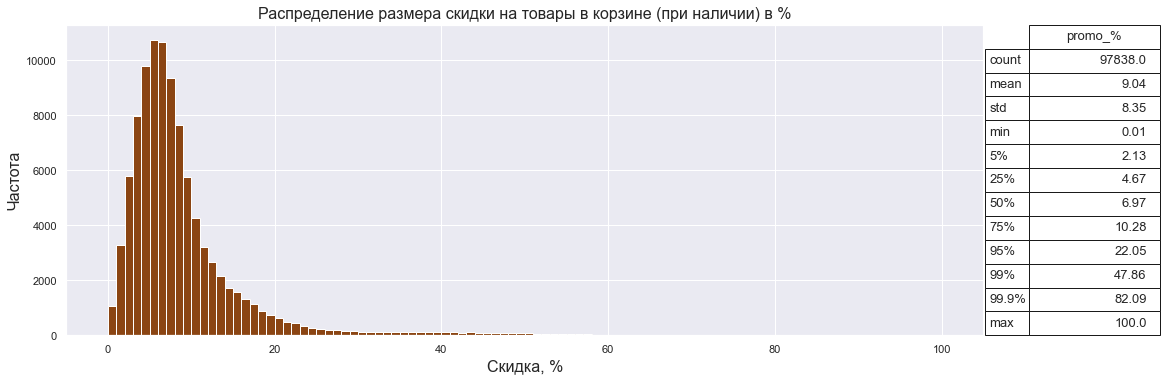

In [84]:
ser = orders[orders['promo_%']>0]['promo_%']
    
fig, ax = plt.subplots(1, 2, gridspec_kw={'width_ratios': [7, 1]}, figsize=(16,5))
fig.tight_layout()
    
ax[0].hist(ser, bins=100, color='saddlebrown')
ax[0].set_title('Распределение размера скидки на товары в корзине (при наличии) в %', fontsize=16)
ax[0].set_ylabel('Частота', fontsize=16)
ax[0].set_xlabel('Скидка, %', fontsize=16)
    
dfxx = ser.describe(percentiles =[.05, .25, .50, .75, .95, .99, .999]).to_frame().round(2)
ax[1].axis('off')
mpl_table = ax[1].table(cellText = dfxx.values, rowLabels = dfxx.index, bbox=[0, 0, 1, 1], colLabels=dfxx.columns)
mpl_table.auto_set_font_size(False)
mpl_table.set_fontsize(13)

In [85]:
orders[orders['promo_%']>99]

id  user_id  total_cost   cost  item_total  promo_total  \
45664    792088   149079         0.0    0.0           1       -400.0   
320701  5126949  1758530        98.0  249.0           0       -199.0   
503064  2542938   998168         0.0  199.0           1       -230.0   

        total_weight  total_quantity    state          shipped_at  \
45664           9130              16  shipped 2018-09-14 07:51:55   
320701         10950              11  shipped 2019-12-11 05:46:06   
503064          6500              10  shipped 2019-10-01 14:32:29   

                created_at  ship_address_id  store_id  delivery_window_id  \
45664  2018-09-13 22:57:54           949476         2              242389   
320701 2019-12-10 20:02:23          6751812        12              943952   
503064 2019-09-30 16:10:39          3655834        63              749422   

           promo_%  
45664    99.750623  
320701  100.000000  
503064   99.567100

**Промежуточные выводы:**
* В некоторых случаях скидка на товары в корзине доходит до 100% (2 заказа со скидкой строки > 99,5% и 1 заказ - 100%) Причины - ?

#### Повторные заказы

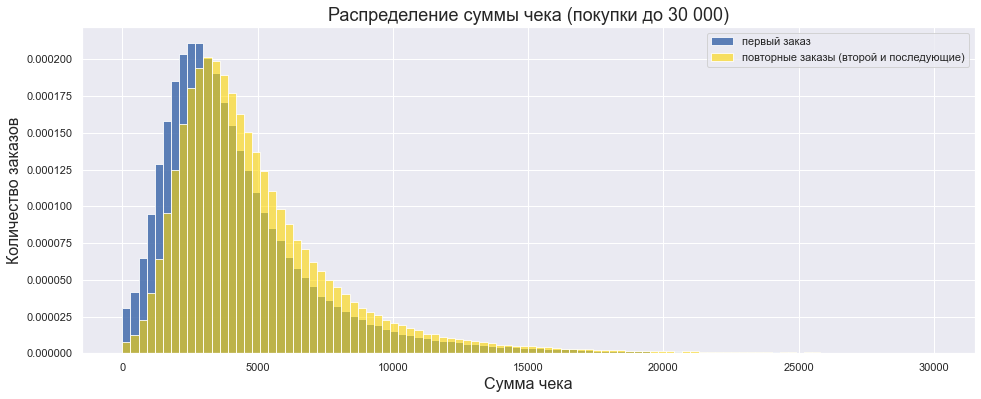

In [86]:
sns.histplot(orders_merged[orders_merged['item_total']<30000].query('buy_num==1')['item_total'],
             bins=100, stat='density', alpha=0.9)
sns.histplot(orders_merged[orders_merged['item_total']<30000].query('buy_num>=2')['item_total'], 
             bins=100, stat='density', alpha=0.6,
             color='gold')
plt.legend(labels=['первый заказ', 'повторные заказы (второй и последующие)'])
plt.title('Распределение суммы чека (покупки до 30 000)', fontsize=18) 
plt.ylabel('Количество заказов', fontsize=16)
plt.xlabel('Сумма чека', fontsize=16);

In [87]:
#каждая строка включает данные по первому и второму заказам покупателя
orders12 = orders_merged.query('buy_num==1').merge(orders_merged.query('buy_num==2'), 
                                              how='right', on=['user_id'], suffixes=('_1', '_2'))

In [88]:
orders12.head(3)

id_1  user_id  total_cost_1  cost_1  item_total_1  promo_total_1  \
0  758108.0   120099         249.0   249.0        8249.0            0.0   
1  758165.0    41159         299.0   299.0        3741.0         -500.0   
2  756963.0   139682           0.0     0.0        7096.0            0.0   

   total_weight_1  total_quantity_1  state_1        shipped_at_1  \
0           800.0               1.0  shipped 2018-08-27 08:59:39   
1          5715.0              15.0  shipped 2018-08-30 18:44:17   
2         49435.0              71.0  shipped 2018-08-26 16:28:41   

         created_at_1  ship_address_id_1  store_id_1  delivery_window_id_1  \
0 2018-08-26 16:18:45           882577.0         1.0              227241.0   
1 2018-08-26 16:58:06           866972.0         1.0              229952.0   
2 2018-08-26 05:43:20           888394.0         1.0              226460.0   

          starts_at_1           ends_at_1    time_zone_1  city_1  \
0 2018-08-27 07:00:00 2018-08-27 09:00:00  Europe/Moscow     1.0   
1 2018-08-30 17:00:00 2018-08-30 19:00:00  Europe/Moscow     1.0   
2 2018-08-26 15:00:00 2018-08-26 17:00:00  Europe/Moscow     1.0   

   retailer_id_1      lat_1      lon_1 elevator_1 floor_1 city_name_1  \
0            1.0  55.919735  37.708629  passenger       1      Moscow   
1            1.0  55.881836  37.653857  passenger      14      Moscow   
2            1.0  55.858791  37.638656  passenger       8      Moscow   

   delivery_time_h_1  deliv_late_h_1 yearmonth_1  cr_weekday_1  sh_weekday_1  \
0          16.681667             0.0     2018-08           6.0           0.0   
1          97.769722             0.0     2018-08           6.0           3.0   
2          10.755833             0.0     2018-08           6.0           6.0   

   buy_num_1    id_2  total_cost_2  cost_2  item_total_2  promo_total_2  \
0        1.0  759089         448.0   448.0         10868            0.0   
1        1.0  760023         299.0   299.0          6204         -300.0   
2        1.0  761090         348.0   348.0          6097            0.0   

   total_weight_2  total_quantity_2  state_2        shipped_at_2  \
0           50800                51  shipped 2018-09-04 09:05:58   
1           11465                23  shipped 2018-10-22 18:29:30   
2           22758                62  shipped 2018-08-29 08:40:24   

         created_at_2  ship_address_id_2  store_id_2  delivery_window_id_2  \
0 2018-08-27 09:02:40             890175           1                234077   
1 2018-08-27 15:39:08             891367           1                274755   
2 2018-08-28 07:43:44             888483           1                229112   

          starts_at_2           ends_at_2    time_zone_2  city_2  \
0 2018-09-04 07:00:00 2018-09-04 09:00:00  Europe/Moscow       1   
1 2018-10-22 16:00:00 2018-10-22 18:00:00  Europe/Moscow       1   
2 2018-08-29 07:00:00 2018-08-29 09:00:00  Europe/Moscow       1   

   retailer_id_2      lat_2      lon_2 elevator_2 floor_2 city_name_2  \
0              1  55.919735  37.708629  passenger       1      Moscow   
1              1  55.881836  37.653857  passenger      14      Moscow   
2              1  55.858791  37.638656  passenger       8      Moscow   

   delivery_time_h_2  deliv_late_h_2 yearmonth_2  cr_weekday_2  sh_weekday_2  \
0         192.055000        0.099444     2018-08             0             1   
1        1346.839444        0.491667     2018-08             0             0   
2          24.944444        0.000000     2018-08             1             2   

   buy_num_2  
0          2  
1          2  
2          2

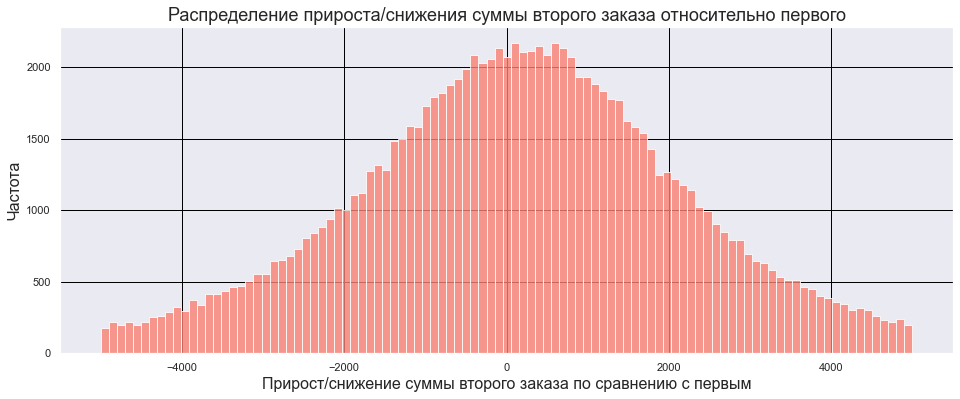

In [89]:
plt.hist(orders12['item_total_2']-orders12['item_total_1'], color='salmon', bins=101, range=[-5000, 5000], alpha=0.8)
plt.grid(color='black')
plt.title('Распределение прироста/снижения суммы второго заказа относительно первого', fontsize=18) 
plt.ylabel('Частота', fontsize=16)
plt.xlabel('Прирост/снижение суммы второго заказа по сравнению с первым', fontsize=16);

In [90]:
print('Средний чек первого заказа:', orders12['item_total_1'].mean())
print('Средний чек второго заказа:', orders12['item_total_2'].mean())
print('Прирост среднего чека:', orders12['item_total_2'].mean() - orders12['item_total_1'].mean())

Средний чек первого заказа: 4762.849648186126
Средний чек второго заказа: 4843.067813237412
Прирост среднего чека: 80.21816505128663


* Сдвиг относительно нуля незначительный. В среднем есть небольшой прирост на 80 единиц (вероятно рублей).

#### Статус

In [91]:
orders['state'].value_counts() #normalize = True

shipped     720404
canceled        15
pending         12
shipping         1
ready            1
Name: state, dtype: int64

* значения отличные от "shipped" крайне редки. Логики статуса не понимаю.

#### Попадание в окно доставки

In [92]:

#посмотрим что с попаданием в окно доставки
orders_merged['deliv_late_h'] = 0

late = orders_merged['shipped_at'] > orders_merged['ends_at'] #доставлено с опазданием
early = orders_merged['shipped_at'] < orders_merged['starts_at'] #доставлено раньше срока

orders_merged.loc[late,'deliv_late_h'] = (orders_merged[late]['shipped_at'] - orders_merged[late]['ends_at']).dt.total_seconds()/60/60
orders_merged.loc[early,'deliv_late_h'] = (orders_merged[early]['shipped_at']-orders_merged[early]['starts_at']).dt.total_seconds()/60/60

In [93]:
_in_win = (orders_merged['deliv_late_h']==0).sum() #попали в окно
_len = len(orders_merged.index) #всего доставок
_earlier_24h = (orders_merged['deliv_late_h']<-24).sum()
_later_24h = (orders_merged['deliv_late_h']>24).sum()

print('Попадают в окно доставки:', _in_win, '({:.2%})'.format(_in_win/_len))
print('Доставлено раньше срока:', early.sum(), '({:.2%})'.format(early.sum()/_len))
print('Доставлено с опазданием:', late.sum(), '({:.2%})'.format(late.sum()/_len))
print('В том числе')
print('Раньше срока на 24 часа и более:', _earlier_24h, '({:.2%})'.format(_earlier_24h.sum()/_len))
print('Позже срока на 24 часа и более:', _later_24h, '({:.2%})'.format(_later_24h.sum()/_len))

Попадают в окно доставки: 534160 (74.15%)
Доставлено раньше срока: 53266 (7.39%)
Доставлено с опазданием: 132957 (18.46%)
В том числе
Раньше срока на 24 часа и более: 235 (0.03%)
Позже срока на 24 часа и более: 417 (0.06%)


In [94]:
orders_merged

id  user_id  total_cost   cost  item_total  promo_total  \
0        756927   139676         0.0    0.0        5015          0.0   
1        756963   139682         0.0    0.0        7096          0.0   
2        756983    63967       299.0  299.0        2724       -250.0   
3        756985   139687         0.0    0.0        3471          0.0   
4        757066   119006       299.0  299.0        1254          0.0   
...         ...      ...         ...    ...         ...          ...   
720378  5423310  1676786       258.0  258.0        4777          0.0   
720379  5423488  1832586        98.0  238.0        1864          0.0   
720380  5424466  1318477       158.0  238.0        2769       -200.0   
720381  5426016  1116106       158.0  238.0        2876          0.0   
720382  5426868  1389756       158.0  238.0        4376          0.0   

        total_weight  total_quantity    state          shipped_at  \
0              37708              39  shipped 2018-08-26 15:01:42   
1              49435              71  shipped 2018-08-26 16:28:41   
2              11590              32  shipped 2018-08-26 15:09:11   
3               9915              13  shipped 2018-08-26 18:57:01   
4              15022              24  shipped 2018-08-26 13:46:48   
...              ...             ...      ...                 ...   
720378         43286              71  shipped 2019-12-18 15:45:12   
720379          4245              13  shipped 2019-12-18 12:44:16   
720380          4780               7  shipped 2019-12-18 13:16:08   
720381         13385              34  shipped 2019-12-18 14:28:56   
720382         16733              35  shipped 2019-12-18 13:19:32   

                created_at  ship_address_id  store_id  delivery_window_id  \
0      2018-08-26 02:06:55           888330         1              226459   
1      2018-08-26 05:43:20           888394         1              226460   
2      2018-08-26 06:12:13           888420         1              226459   
3      2018-08-26 06:13:59           888422         1              226462   
4      2018-08-26 07:40:58           870688         1              226458   
...                    ...              ...       ...                 ...   
720378 2019-12-18 09:16:28          6346125       235              973254   
720379 2019-12-18 09:20:18          7120759       235              973253   
720380 2019-12-18 09:41:28          6881231       235              973252   
720381 2019-12-18 10:18:37          5606095       235              973254   
720382 2019-12-18 10:36:52          6661630       235              973254   

                 starts_at             ends_at      time_zone  city  \
0      2018-08-26 14:00:00 2018-08-26 16:00:00  Europe/Moscow     1   
1      2018-08-26 15:00:00 2018-08-26 17:00:00  Europe/Moscow     1   
2      2018-08-26 14:00:00 2018-08-26 16:00:00  Europe/Moscow     1   
3      2018-08-26 17:00:00 2018-08-26 19:00:00  Europe/Moscow     1   
4      2018-08-26 13:00:00 2018-08-26 15:00:00  Europe/Moscow     1   
...                    ...                 ...            ...   ...   
720378 2019-12-18 14:00:00 2019-12-18 16:00:00      Asia/Omsk    13   
720379 2019-12-18 13:00:00 2019-12-18 15:00:00      Asia/Omsk    13   
720380 2019-12-18 12:00:00 2019-12-18 14:00:00      Asia/Omsk    13   
720381 2019-12-18 14:00:00 2019-12-18 16:00:00      Asia/Omsk    13   
720382 2019-12-18 14:00:00 2019-12-18 16:00:00      Asia/Omsk    13   

        retailer_id        lat        lon   elevator floor city_name  \
0                 1  55.855683  37.644165       None     3    Moscow   
1                 1  55.858791  37.638656  passenger     8    Moscow   
2                 1  55.890288  37.612822  passenger     3    Moscow   
3                 1  55.878475  37.620050       None     4    Moscow   
4                 1  55.825067  37.621798       None     3    Moscow   
...             ...        ...        ...        ...   ...       ...   
720378           15  55.023707  73.42

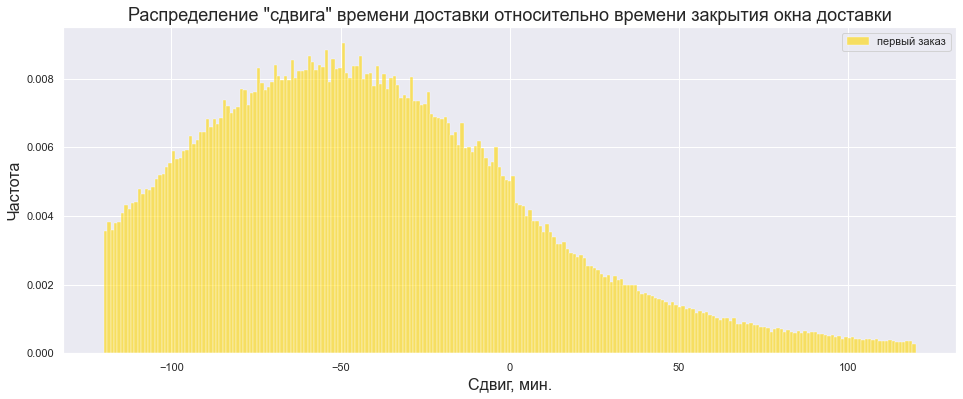

In [95]:
#проверю как распределено количество доставок рядом с "закрытием" окна доставок.
orders_merged['ends_lag_min'] = (orders_merged['shipped_at'] - orders_merged['ends_at']).dt.total_seconds()/60

sns.histplot(orders_merged.query('-120<ends_lag_min<120')['ends_lag_min'], bins=239, stat='density', alpha=0.6,
             color='gold')
plt.legend(labels=['первый заказ'])
plt.title('Распределение "сдвига" времени доставки относительно времени закрытия окна доставки', fontsize=18) 
plt.ylabel('Частота', fontsize=16)
plt.xlabel('Сдвиг, мин.', fontsize=16);

In [96]:
orders_merged = orders_merged.drop('ends_lag_min', axis=1)

* Явного пика в 0 нет. Скорее видна кратность 5 минутам (при доставке указывается время кратно 5 минутам) - можно ковырять дальше (возможно такая закономерность не для всех заказов), но сенсации не будет.

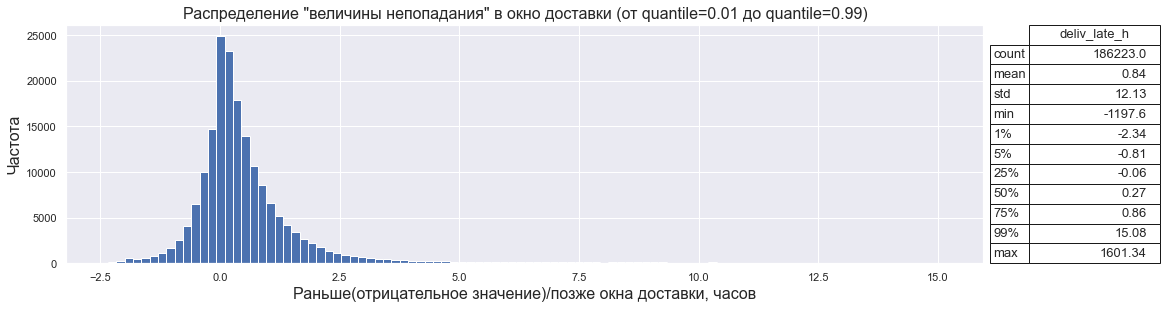

In [97]:
ser = orders_merged[orders_merged['deliv_late_h']!=0]['deliv_late_h']
    
fig, ax = plt.subplots(1, 2, gridspec_kw={'width_ratios': [7, 1]}, figsize=(16,4))
fig.tight_layout()
    
ax[0].hist(ser, bins=100, range=[ser.quantile(0.01), ser.quantile(0.99)]) #
ax[0].set_title('Распределение "величины непопадания" в окно доставки (от quantile=0.01 до quantile=0.99)', fontsize=16)
ax[0].set_ylabel('Частота', fontsize=16)
ax[0].set_xlabel('Раньше(отрицательное значение)/позже окна доставки, часов', fontsize=16)
    
dfxx = ser.describe(percentiles =[.01, .05, .25, .50, .75, .99]).to_frame().round(2)
ax[1].axis('off')
mpl_table = ax[1].table(cellText = dfxx.values, rowLabels = dfxx.index, bbox=[0, 0, 1, 1], colLabels=dfxx.columns)
mpl_table.auto_set_font_size(False)
mpl_table.set_fontsize(13)

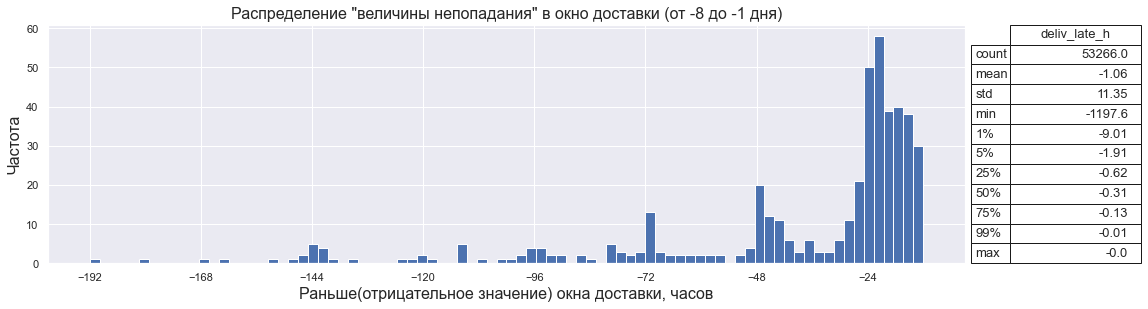

In [98]:
ser = orders_merged[orders_merged['deliv_late_h']<0]['deliv_late_h']
    
fig, ax = plt.subplots(1, 2, gridspec_kw={'width_ratios': [7, 1]}, figsize=(16,4))
fig.tight_layout()
    
ax[0].hist(ser, bins=84, range=[-192, -12]) #
ax[0].set_title('Распределение "величины непопадания" в окно доставки (от -8 до -1 дня)', fontsize=16)
ax[0].set_ylabel('Частота', fontsize=16)
ax[0].set_xlabel('Раньше(отрицательное значение) окна доставки, часов', fontsize=16)
ax[0].set_xticks([-24, -48, -72, -96, -120, -144, -168, -192])
    
dfxx = ser.describe(percentiles =[.01, .05, .25, .50, .75, .99]).to_frame().round(2)
ax[1].axis('off')
mpl_table = ax[1].table(cellText = dfxx.values, rowLabels = dfxx.index, bbox=[0, 0, 1, 1], colLabels=dfxx.columns)
mpl_table.auto_set_font_size(False)
mpl_table.set_fontsize(13)

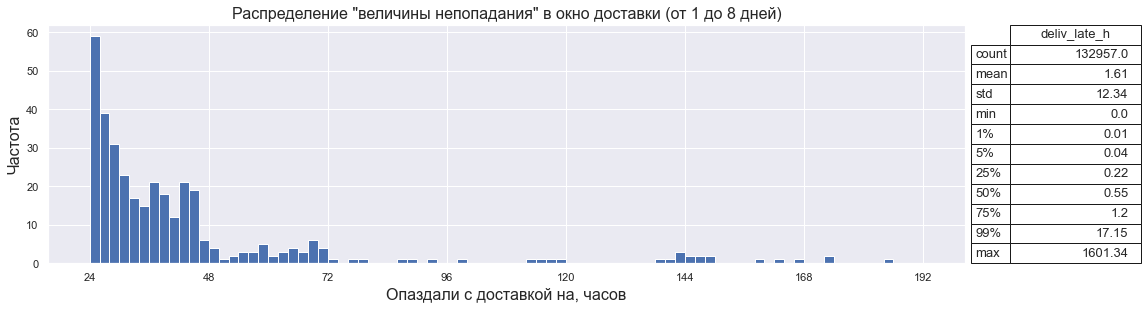

In [99]:
ser = orders_merged[orders_merged['deliv_late_h']>0]['deliv_late_h']
    
fig, ax = plt.subplots(1, 2, gridspec_kw={'width_ratios': [7, 1]}, figsize=(16,4))
fig.tight_layout()
    
ax[0].hist(ser, bins=84, range=[24, 192]) #
ax[0].set_title('Распределение "величины непопадания" в окно доставки (от 1 до 8 дней)', fontsize=16)
ax[0].set_ylabel('Частота', fontsize=16)
ax[0].set_xlabel('Опаздали с доставкой на, часов', fontsize=16)
ax[0].set_xticks([24, 48, 72, 96, 120, 144, 168, 192])
    
dfxx = ser.describe(percentiles =[.01, .05, .25, .50, .75, .99]).to_frame().round(2)
ax[1].axis('off')
mpl_table = ax[1].table(cellText = dfxx.values, rowLabels = dfxx.index, bbox=[0, 0, 1, 1], colLabels=dfxx.columns)
mpl_table.auto_set_font_size(False)
mpl_table.set_fontsize(13)

In [100]:
#попадание в доставку по месяцам (Москва)
_dict={}
for _ym in sorted(orders_merged.query('city_name=="Moscow"')['yearmonth'].unique()):
    b={}
    _df = orders_merged.query('city_name=="Moscow"')[orders_merged['yearmonth']==_ym]
    b['ord_count'] = len(_df.index)
    b['del_early_%'] = len(_df.query('deliv_late_h < 0').index)/b['ord_count']*100
    b['del_early_mean'] = _df.query('deliv_late_h < 0')['deliv_late_h'].mean()
    b['del_ok_%'] = len(_df.query('deliv_late_h == 0').index)/b['ord_count']*100
    b['del_late_%'] = len(_df.query('deliv_late_h > 0').index)/b['ord_count']*100
    b['del_late_mean'] = _df.query('deliv_late_h > 0')['deliv_late_h'].mean()
    _dict[str(_ym)] = b
    
_table = pd.DataFrame(_dict).T

_table.style.format('{:.2f}').bar(subset=['ord_count', 'del_early_%', 'del_early_mean', 'del_ok_%', 'del_late_%',
                                                'del_late_mean'], 
                                       align='mid', color=['skyblue', 'Chartreuse'], width=98).set_caption(
    'Попадание в доставку по месяцам Москва')

<ipython-input-100-9512b73995ae>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  _df = orders_merged.query('city_name=="Moscow"')[orders_merged['yearmonth']==_ym]


* 74% процента доставок попадают в "окно", 7,5% заказов доставлено раньше, 18,5% с опазданием.
* Среди доставленных раньше срока прослеживаются пики доставок кратно 24 часам (попадают в окно, но на 1,2,3 дня раньше). Возможно связано с ошибкой при оформлении заказа или доставки (не учитывают дату).


#### Города

In [101]:
#как меняются заказы в зависимости от города
_dict={}
for _city in city['city_name']:
    b={}
    _df = orders_merged[orders_merged['city_name']==_city]
    b['ord_count'] = len(_df.index)
    b['ord_ratio'] = b['ord_count']/720430*100
    b['2ord_%'] = len(_df.query('buy_num==2').index)/b['ord_count'] #доля повторных заказов
    b['item_mean'] = _df['item_total'].mean()   
    b['total_cost_mean'] = _df['total_cost'].mean()
    b['promo_%'] = len(_df.query('promo_total<0').index)/len(_df.index)
    b['promo_total_mean'] = _df['promo_total'].mean()
    b['quantity_mean'] = _df['total_quantity'].mean()
    b['delivery_h_mean'] =_df['delivery_time_h'].mean()
    b['in_time_%'] = (_df['deliv_late_h']==0).mean()
    _dict[str(_city)] = b
    
_table = pd.DataFrame(_dict).T

_table.style.format('{:.2f}').bar(subset=['ord_count', 'total_cost_mean', 'item_mean', 'promo_%', 'promo_total_mean', 
                                          'quantity_mean', 'delivery_h_mean', 'in_time_%'], 
                                       align='mid', color=['skyblue', 'Chartreuse'], width=98).set_caption(
    'Сводная таблица заказов по городам')

* на Москву приходится 66% строк 
* Средний чек в Москве на 40-50% выше по сравнению с другими городами (больше единиц товара и вес).
* В Уфе промо-коды на товары в корзине применяюлись на 58% чаще чем в Москве.
* Время доставки в Мск заметно выше чем в других городах

In [102]:
orders_merged.query('deliv_late_h < 0')['city_name'].value_counts()

Moscow             33801
Kazan               5691
Rostov-on-Don       4977
Samara              4119
Nizhny Novgorod     2180
Ufa                 1495
Omsk                1003
Name: city_name, dtype: int64

In [103]:
#сводная таблица заказов по городам помесячно
pivot = orders_merged.pivot_table(index=['yearmonth'], 
                               columns=['city'],
                               aggfunc={'item_total': ['count', 'mean'], 'total_quantity': 'mean'})

pivot.style.format('{:.0f}').bar(align='mid', color=['#ff9999'], width=95).set_caption(
    'Cводная таблица заказов по городам помесячно')

* **На фоне растущего среднего чека и количества позиций выделяется спад в августе-сентябре 2019г**

**Выводы по orders:**
* В срезе данные по 720 433 заказам 257 827 пользователей за период 26.08.2018 - 18.12.2019
* Среднее количество заказов покупателя - 2.8 
* 10 и более заказов только у 5% покупателей. Есть покупатели с 50-500 заказами. Юрлица? 
* Нет повторной покупки у 56% покупателей
* Средний(медианный) чек - 5000 (4000), но есть и большие суммы (56 заказов на сумму более 150 тыс.)
* 13,6% покупок с промо-кодом на товары (их средняя скидка=379)



* для доставок со сроком 3-14 дней выше средняя финальная стоимость доставки (ниже/реже промо)? проверить!

* **Провал в доставках с 16:00 06.08.2019 до 08:30 08.08.2019**

* **высокая плотность доставок со сроком около 2 минут. Технические/внутренние/задним числом?**

* **в shipped_at много значений времени "округленных" до целого часа (00 минут 00 секунд).

* есть особенности доставки из магазинов (store_id [ 8, 12, 14, 18, 70], особое внимание 18) - встречаются крайне низкие сроки доставки
* также необычное поведение у user_id=215536 - 405 заказов из store_id=18


* **средняя скидка на товары в корзине в пт-вс выше чем в другие дни - проверить гипотезу!**

**Выбросы:**
* доставлены раньше чем заказаны (id = 980548, 980564, 980590)
* total_cost<0 (id= 795110, 802572, 802465)
* для user_id==1045400 две доставки с высокой круглой ценой (25000 и 30000)
* есть заказы со сроком доставки > 90 дней (в т.ч. 6-12 месяцев) - выбросы?

### addresses - визуализация геоданных

Для визуализации геоданных используем folium

In [104]:
orders_folium = orders_merged[['lat', 'lon']].copy()

#для отладки использую 10% случайных строк (т.к. карта на полных данных "вешает" блокнот)
orders_folium = orders_folium.sample(72000)
#orders_folium.duplicated().sum()

Встречается много заказов оформленных по совпадающим адресам. На карте такие заказы сольются в точку. Избежать этого можно сдвинув координаты на небольшую случайную величину (1/10000 градуса широты(долготы) - примерно соответствует 11(6) метрам).

In [105]:
#сдвигаем координаты на небольшую случайную величину
for col in ['lat', 'lon']:
    orders_folium[col] = orders_folium.apply(rand_offset, axis=1)

In [106]:
base_map = folium.Map(location=[52.0, 55.0], control_scale=False, zoom_start=5)

data = orders_folium
HeatMap(data=data, radius=6, max_zoom=15, gradient={.3: 'blue', .5: 'lime', .7: 'orange', .8: 'red'},
        blur=9).add_to(base_map)

base_map

Можно еще попробовать HeatMapWithTime ()
https://www.machinelearningmastery.ru/data-101s-spatial-visualizations-and-analysis-in-python-with-folium-39730da2adf/

In [107]:
#есть ли выпадающие значени координат
_dict={}
for _city in city['city_name'].head(7):
    b={}
    _df = orders_merged[orders_merged['city_name']==_city]
    b['ord_count'] = len(_df.index)
    b['lat_min'] = _df['lat'].min()
    b['lat_mean'] = _df['lat'].mean()
    b['lat_max'] = _df['lat'].max()
    b['lon_min'] = _df['lon'].min()
    b['lon_mean'] = _df['lon'].mean()
    b['lon_max'] = _df['lon'].max() 
 
    _dict[str(_city)] = b
    
_table = pd.DataFrame(_dict).T

_table.style.format('{:.2f}').set_caption(
    'Минимальные средние и максимальные значения координат по городам')

In [108]:
#куда попадает выброс ('lat > 57')
base_map = folium.Map(location=[60.0, 30.0], control_scale=False, zoom_start=7)

data = orders_merged.query('lat > 57').loc[:, ['lat', 'lon']]
HeatMap(data=data, radius=6, max_zoom=15, gradient={.3: 'blue', .5: 'lime', .7: 'orange', .8: 'red'},
        blur=9).add_to(base_map)

base_map

In [109]:
orders_merged[orders_merged['lat']>57]

id  user_id  total_cost   cost  item_total  promo_total  \
360508  2900771  1138025        98.0  238.0        1098          0.0   

        total_weight  total_quantity    state          shipped_at  \
360508          2745              11  shipped 2019-10-25 15:54:36   

                created_at  ship_address_id  store_id  delivery_window_id  \
360508 2019-10-21 08:47:00          4175845        14              808679   

                 starts_at             ends_at      time_zone  city  \
360508 2019-10-25 16:00:00 2019-10-25 18:00:00  Europe/Moscow     1   

        retailer_id        lat        lon elevator floor city_name  \
360508            1  60.014985  30.359079     none     7    Moscow   

        delivery_time_h  deliv_late_h yearmonth  cr_weekday  sh_weekday  \
360508       103.126667         -0.09   2019-10           0           4   

        buy_num  
360508        1

**Промежуточные выводы:**
* для заказа id=2900771 (city=1 - Москва) указаны координаты адреса доставки в СПб

### replacements - замены, cancellations - отмены

В разделе разбираю 3 возможных ситуации:
* ok - в заказе нет замен или отмен
* replaced - не нашли позицию (позиции), но удалось подобрать замену (замены) не отменяя ни одной позиции из заказа
* cancelled - хотя бы для 1 позиции из заказа не получилось подобрать замену

In [110]:
for df in [replacements, cancellations]:
    print(df['state'].value_counts())
    display(df.head(3))
    display(df['order_id'].value_counts().describe())
    print('#'*45)

replaced    1250244
Name: state, dtype: int64


order_id  item_id     state
0    480785  6466916  replaced
1    480785  6466940  replaced
2    480785  6466778  replaced

count    449165.000000
mean          2.783485
std           2.295636
min           1.000000
25%           1.000000
50%           2.000000
75%           4.000000
max          42.000000
Name: order_id, dtype: float64

#############################################
canceled    1441605
Name: state, dtype: int64


order_id  item_id     state
0    480443  5333890  canceled
1    480443  5333777  canceled
2    480443  5334118  canceled

count    493995.000000
mean          2.918258
std           2.759173
min           1.000000
25%           1.000000
50%           2.000000
75%           4.000000
max         118.000000
Name: order_id, dtype: float64

#############################################


In [111]:
#количество замен/отмен в заказе
ser = replacements.groupby(['order_id'])['state'].count()
orders_merged = orders_merged.merge(ser.rename('replaced'), how='left', left_on='id', right_on='order_id')
ser = cancellations.groupby(['order_id'])['state'].count()
orders_merged = orders_merged.merge(ser.rename('cancelled'), how='left', left_on='id', right_on='order_id')
orders_merged[['replaced', 'cancelled']] = orders_merged[['replaced', 'cancelled']].fillna(0)

In [112]:
#нет замен/отмен
orders_merged['is_ok'] = (orders_merged['replaced'] + orders_merged['cancelled'])==0
#есть замена (замены) но нет отмен
orders_merged['is_replaced'] = (
    orders_merged['replaced']>0).astype(int) + (orders_merged['cancelled']==0).astype(int) == 2
#есть отмена
orders_merged['is_cancelled'] = orders_merged['cancelled']>0

In [113]:
orders_merged.head(3)

id  user_id  total_cost   cost  item_total  promo_total  total_weight  \
0  756927   139676         0.0    0.0        5015          0.0         37708   
1  756963   139682         0.0    0.0        7096          0.0         49435   
2  756983    63967       299.0  299.0        2724       -250.0         11590   

   total_quantity    state          shipped_at          created_at  \
0              39  shipped 2018-08-26 15:01:42 2018-08-26 02:06:55   
1              71  shipped 2018-08-26 16:28:41 2018-08-26 05:43:20   
2              32  shipped 2018-08-26 15:09:11 2018-08-26 06:12:13   

   ship_address_id  store_id  delivery_window_id           starts_at  \
0           888330         1              226459 2018-08-26 14:00:00   
1           888394         1              226460 2018-08-26 15:00:00   
2           888420         1              226459 2018-08-26 14:00:00   

              ends_at      time_zone  city  retailer_id        lat        lon  \
0 2018-08-26 16:00:00  Europe/Moscow     1            1  55.855683  37.644165   
1 2018-08-26 17:00:00  Europe/Moscow     1            1  55.858791  37.638656   
2 2018-08-26 16:00:00  Europe/Moscow     1            1  55.890288  37.612822   

    elevator floor city_name  delivery_time_h  deliv_late_h yearmonth  \
0       None     3    Moscow        12.913056           0.0   2018-08   
1  passenger     8    Moscow        10.755833           0.0   2018-08   
2  passenger     3    Moscow         8.949444           0.0   2018-08   

   cr_weekday  sh_weekday  buy_num  replaced  cancelled  is_ok  is_replaced  \
0           6           6        1       0.0        8.0  False        False   
1           6           6        1       0.0        9.0  False        False   
2           6           6        1       0.0        4.0  False        False   

   is_cancelled  
0          True  
1          True  
2          True

In [114]:
#Добавляю строку 'TOTAL' к списку городов
city.loc[len(city)] = {'city':0, 'city_name':'TOTAL'}
_dict={}
for _city in city['city_name']:
    b={}
    if _city!='TOTAL':
        _df = orders_merged[orders_merged['city_name']==_city]
    else:
        _df = orders_merged
    
    b['ord_count'] = len(_df.index)
    b['ok_order%'] = _df['is_ok'].mean()*100 #без замены и отмены
    b['replaced_order%'] = _df['is_replaced'].mean()*100 #замена без отмены
    b['cancelled_order%'] = _df['is_cancelled'].mean()*100 #отмена (в т.ч. с заменами)
    b['replaced_mean'] = _df['replaced'].mean() #среднее количество замен в заказах
    b['cancelled_mean'] = _df['cancelled'].mean()#среднее количество отмен в заказах
    b['in_time_%'] = (_df['deliv_late_h']==0).mean()  
    _dict[str(_city)] = b
    
_table = pd.DataFrame(_dict).T

_table.style.format('{:.2f}').bar(subset=['ord_count'], align='mid', color=['skyblue'], width=45
            ).bar(subset=['ok_order%'], align='mid', color=['#99ff99'], width=35
            ).bar(subset=['replaced_order%'], align='mid', color=['#ffff99'], width=37
            ).bar(subset=['cancelled_order%'], align='mid', color=['#ff9999'], width=99
            ).bar(subset=['replaced_mean', 'cancelled_mean', 'in_time_%'], align='mid', color=['skyblue'], width=70
            ).set_caption('Доля заказов с заменами/отменами по городам')                

* В Самаре и Омске выше процент заказов без замен/отмен. При этом в Омске чаще удается подобрать замену недостающей позиции (выше % замен и ниже % отказов от позиции). 

In [115]:
_dict={}
for _day in range(7):
    b={}
    _df = orders_merged[orders_merged['cr_weekday']==_day]
    b['ord_count'] = len(_df.index)
    b['ok_order%'] = _df['is_ok'].mean()*100 #без замены и отмены
    b['replaced_order%'] = _df['is_replaced'].mean()*100 #замена без отмены
    b['cancelled_order%'] = _df['is_cancelled'].mean()*100 #отмена (в т.ч. с заменами)
    b['replaced_mean'] = _df['replaced'].mean() #среднее количество замен в заказах
    b['cancelled_mean'] = _df['cancelled'].mean()#среднее количество отмен в заказах
    _dict[str(_day)] = b
    
_table = pd.DataFrame(_dict).T

_table.style.format('{:.2f}').bar(subset=['ord_count'], align='mid', color=['skyblue'], width=45
                            ).bar(subset=['ok_order%'], align='mid', color=['#99ff99'], width=35
                            ).bar(subset=['replaced_order%'], align='mid', color=['#ffff99'], width=37
                            ).bar(subset=['cancelled_order%'], align='mid', color=['#ff9999'], width=99
                            ).bar(subset=['replaced_mean', 'cancelled_mean'], align='mid', color=['skyblue'], width=70
                            ).set_caption('Доля заказов с заменами/отменами по дням недели')

* Отмены чаще приходятся на заказы созданные в сб. вс.

In [116]:
_dict={}
for _ym in sorted(orders_merged['yearmonth'].unique()):
    b={}
    _df = orders_merged[orders_merged['yearmonth']==_ym]
    b['ord_count'] = len(_df.index)
    b['ok_order%'] = _df['is_ok'].mean()*100 #без замены и отмены
    b['replaced_order%'] = _df['is_replaced'].mean()*100 #замена без отмены
    b['cancelled_order%'] = _df['is_cancelled'].mean()*100 #отмена (в т.ч. с заменами)
    b['replaced_mean'] = _df['replaced'].mean() #среднее количество замен в заказах
    b['cancelled_mean'] = _df['cancelled'].mean()#среднее количество отмен в заказах
    _dict[str(_ym)] = b
    
_table = pd.DataFrame(_dict).T

_table.style.format('{:.2f}').bar(subset=['ord_count'], align='mid', color=['skyblue'], width=45
                            ).bar(subset=['ok_order%'], align='mid', color=['#99ff99'], width=35
                            ).bar(subset=['replaced_order%'], align='mid', color=['#ffff99'], width=37
                            ).bar(subset=['cancelled_order%'], align='mid', color=['#ff9999'], width=99
                            ).bar(subset=['replaced_mean', 'cancelled_mean'], align='mid', color=['skyblue'], width=70
                            ).set_caption('Доля заказов с заменами/отменами по месяцам')

In [117]:
#как выглядят заказы с разными сроками доставки
_dict={}
_h = [0, 8, 16, 24, 72, 168, 336, 720, 24000]
for i in range(len(_h)-1):
    b={}
    _df = orders_merged[orders_merged['delivery_time_h']>_h[i]]#строки со сроком выполнения доставки больше _day
    _df = _df[_df['delivery_time_h']<=_h[i+1]]
    b['ord_count'] = len(_df.index)
    b['ord_%'] = b['ord_count']/720430*100
#    b['user_count'] = _df['user_id'].nunique() 
    b['item_mean'] = _df['item_total'].mean()
    b['total_cost_mean'] = _df['total_cost'].mean()
#    b['cost_mean'] = _df['cost'].mean()
    b['promo_total_mean'] = _df['promo_total'].mean()
    b['total_weight_mean'] = _df['total_weight'].mean()
    b['total_quantity_mean'] = _df['total_quantity'].mean()
    b['in_time_%'] = (_df['deliv_late_h']==0).mean()
    b['ok_order%'] = _df['is_ok'].mean()    
    _dict[str(_h[i])+'-'+str(_h[i+1])+' ч.'] = b
_table = pd.DataFrame(_dict).T

_table.style.format('{:.2f}').bar(subset=['ord_count', 'item_mean', 'total_cost_mean', 'promo_total_mean', 
                                          'total_weight_mean', 'total_quantity_mean', 'in_time_%', 'ok_order%'], 
                                       align='mid', color=['skyblue', 'Chartreuse'], width=99).set_caption(
    'Сводная таблица заказов с разными сроками доставки')

* заказы, доставленные в течении 24 часов имеют меньшее количество позиций и чаще без замен/отмен

In [118]:
#сводная таблица заказов по городам помесячно
pivot = orders_merged.pivot_table(index=['yearmonth'], 
                               columns=['city'],
                               aggfunc={#'item_total': ['count', 'mean'], 
                                        'is_ok': 'mean',
     #                                  'total_weight': 'mean',
                                       'is_replaced': 'mean',
                                       'is_cancelled': 'mean'})

pivot[['is_ok', 'is_replaced', 'is_cancelled']].style.format('{:.2f}').bar(
    align='mid', color=['#ff9999'], width=95).set_caption('Доля заказов с заменами/отменами по городам помесячно')

In [119]:
#сводная таблица заказов по городам помесячно
pivot = orders_merged.pivot_table(index=['yearmonth'], 
                               columns=['city'],
                               aggfunc={#'item_total': ['count', 'mean'], 
                                        'total_quantity': 'mean',
     #                                  'total_weight': 'mean',
                                       'replaced': 'mean',
                                       'cancelled': 'mean'})

pivot[['total_quantity', 'replaced', 'cancelled']].style.format('{:.2f}').bar(
    align='mid', color=['#ff9999'], width=95).set_caption('Среднее количество замен/отмен по городам помесячно')

* Рост доли заказов с отказами и снижение количества единиц товара в заказах в августе 2018
* Значительный рост количества отказов в октябре-декабре 2019

In [120]:
orders_merged.head(3)

id  user_id  total_cost   cost  item_total  promo_total  total_weight  \
0  756927   139676         0.0    0.0        5015          0.0         37708   
1  756963   139682         0.0    0.0        7096          0.0         49435   
2  756983    63967       299.0  299.0        2724       -250.0         11590   

   total_quantity    state          shipped_at          created_at  \
0              39  shipped 2018-08-26 15:01:42 2018-08-26 02:06:55   
1              71  shipped 2018-08-26 16:28:41 2018-08-26 05:43:20   
2              32  shipped 2018-08-26 15:09:11 2018-08-26 06:12:13   

   ship_address_id  store_id  delivery_window_id           starts_at  \
0           888330         1              226459 2018-08-26 14:00:00   
1           888394         1              226460 2018-08-26 15:00:00   
2           888420         1              226459 2018-08-26 14:00:00   

              ends_at      time_zone  city  retailer_id        lat        lon  \
0 2018-08-26 16:00:00  Europe/Moscow     1            1  55.855683  37.644165   
1 2018-08-26 17:00:00  Europe/Moscow     1            1  55.858791  37.638656   
2 2018-08-26 16:00:00  Europe/Moscow     1            1  55.890288  37.612822   

    elevator floor city_name  delivery_time_h  deliv_late_h yearmonth  \
0       None     3    Moscow        12.913056           0.0   2018-08   
1  passenger     8    Moscow        10.755833           0.0   2018-08   
2  passenger     3    Moscow         8.949444           0.0   2018-08   

   cr_weekday  sh_weekday  buy_num  replaced  cancelled  is_ok  is_replaced  \
0           6           6        1       0.0        8.0  False        False   
1           6           6        1       0.0        9.0  False        False   
2           6           6        1       0.0        4.0  False        False   

   is_cancelled  
0          True  
1          True  
2          True

In [121]:
#заказы по ритейлеру
_dict={}
for _ret in [1, 8, 15, 16]:
    b={}
    _df = orders_merged[orders_merged['retailer_id']==_ret]
    b['ord_count'] = len(_df.index)
    b['is_ok%'] = _df['is_ok'].mean()*100 #без замены и отмены
    b['replaced_order%'] = _df['is_replaced'].mean()*100 #замена без отмены
    b['cancelled_order%'] = _df['is_cancelled'].mean()*100 #отмена (в т.ч. с заменами)
    b['replaced_mean'] = _df['replaced'].mean() #среднее количество замен в заказах
    b['cancelled_mean'] = _df['cancelled'].mean()#среднее количество отмен в заказах
    _dict[_ret] = b
    
_table = pd.DataFrame(_dict).T

_table.style.format('{:.2f}').bar(subset=['ord_count'], align='mid', color=['skyblue'], width=45
    ).bar(subset=['is_ok%'], align='mid', color=['#99ff99'], width=35
    ).bar(subset=['replaced_order%'], align='mid', color=['#ffff99'], width=37
    ).bar(subset=['cancelled_order%'], align='mid', color=['#ff9999'], width=99
    ).bar(subset=['replaced_mean', 'cancelled_mean'], align='mid', color=['skyblue'], width=70
    ).set_caption('Доля заказов с заменами/отменами по ритейлеру')

* доля заказов с заменами/отменами у ритейлера 1 значительно ниже чем 8, 15

In [122]:
#группировка по 'store_id'
store_orders = orders_merged.pivot_table(index=['store_id'], aggfunc={'cost': ('count', 'mean'), 
                                                             'item_total': ('mean', sum),
                                                             'total_cost': 'mean',
                                                             'total_quantity': 'mean',
                                                             'total_weight': 'mean',
                                                             'is_ok': 'mean'})
store_orders.set_axis(['s_order_count', 's_cost_mean', 'is_ok_%', 's_item_mean', 's_item_sum', 'total_cost_mean', 'u_quantity_mean', 
                      'u_weight_mean'], axis='columns', inplace=True)
display(store_orders.head(3))

s_order_count  s_cost_mean   is_ok_%  s_item_mean   s_item_sum  \
store_id                                                                   
1                 44554   290.694924  0.199578  5703.728217  254123907.0   
2                 52504   289.996801  0.247505  5603.891723  294226731.0   
3                 32802   284.857195  0.216267  4910.403329  161071050.0   

          total_cost_mean  u_quantity_mean  u_weight_mean  
store_id                                                   
1              201.901550        49.755196   28603.662028  
2              204.693434        48.537921   29462.282855  
3              193.484382        42.814219   26047.906591

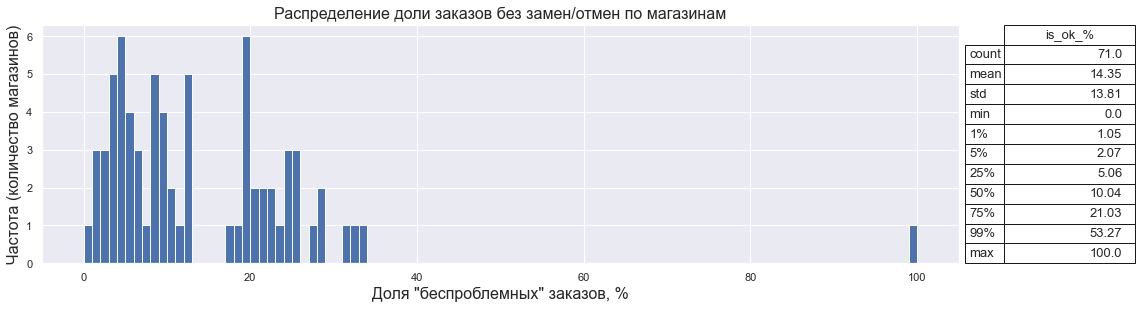

In [123]:
#доля заказов без замен/отмен по магазинам
ser = store_orders['is_ok_%']*100
    
fig, ax = plt.subplots(1, 2, gridspec_kw={'width_ratios': [7, 1]}, figsize=(16,4))
fig.tight_layout()
    
ax[0].hist(ser, bins=100) #, range=[ser.quantile(0.01), ser.quantile(0.99)]
ax[0].set_title('Распределение доли заказов без замен/отмен по магазинам', fontsize=16)
ax[0].set_ylabel('Частота (количество магазинов)', fontsize=16)
ax[0].set_xlabel('Доля "беспроблемных" заказов, %', fontsize=16)
    
dfxx = ser.describe(percentiles =[.01, .05, .25, .50, .75, .99]).to_frame().round(2)
ax[1].axis('off')
mpl_table = ax[1].table(cellText = dfxx.values, rowLabels = dfxx.index, bbox=[0, 0, 1, 1], colLabels=dfxx.columns)
mpl_table.auto_set_font_size(False)
mpl_table.set_fontsize(13)

In [124]:
store_orders[store_orders['is_ok_%']>0.3]

s_order_count  s_cost_mean   is_ok_%  s_item_mean  s_item_sum  \
store_id                                                                  
18                  719   273.382476  0.332406  4460.034771   3206765.0   
112                 859    53.058207  0.329453  3748.082654   3219603.0   
113                 673    12.643388  0.317979  3524.396731   2371919.0   
179                   1   199.000000  1.000000   903.000000       903.0   

          total_cost_mean  u_quantity_mean  u_weight_mean  
store_id                                                   
18             251.214186        33.011127   15539.858136  
112             36.335274        17.863795    8301.861467  
113              7.775632        16.120357    6652.433878  
179            199.000000         1.000000    1000.000000

Из магазина со 100% "беспроблемных" заказов был всего 1 заказ.

### Проверка гипотез
* **средний чек в будни и выходные отличается**

Нулевая гипотеза:

    средний чек в будни и выходные равны.

Альтернативная гипотеза:

    средний чек в будни и выходные отличаются.

In [125]:
week_ithem_total = orders_merged[orders_merged['item_total']<30000].query('sh_weekday <= 4')['item_total']
weekend_ithem_total = orders_merged[orders_merged['item_total']<30000].query('sh_weekday > 4')['item_total']

In [126]:
print('Средний чек в пн.-пт.:', week_ithem_total.mean())
print('Средний чек в сб.-вс.:', weekend_ithem_total.mean())

Средний чек в пн.-пт.: 4842.50907678847
Средний чек в сб.-вс.: 4647.345667878649


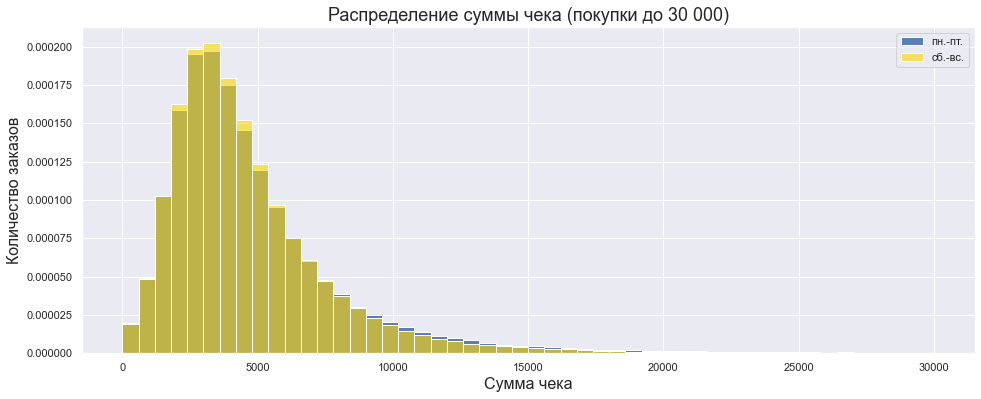

In [127]:
sns.histplot(week_ithem_total, bins=50, stat='density', alpha=0.9)
sns.histplot(weekend_ithem_total, bins=50, stat='density', alpha=0.6, color='gold')
plt.legend(labels=['пн.-пт.', 'сб.-вс.'])
plt.title('Распределение суммы чека (покупки до 30 000)', fontsize=18) 
plt.ylabel('Количество заказов', fontsize=16)
plt.xlabel('Сумма чека', fontsize=16);

In [128]:
print('Дисперсия чека в будни: {:.2f}'.format(np.var(week_ithem_total, ddof=1)))
print('Дисперсия чека в выходные: {:.2f}'.format(np.var(weekend_ithem_total, ddof=1)))

Дисперсия чека в будни: 11820076.73
Дисперсия чека в выходные: 9622609.77


In [129]:
alpha = .05

results = st.ttest_ind(week_ithem_total, weekend_ithem_total, equal_var = False) #т.к. дисперсии для тарифов различны

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 1.0208686975415016e-121
Отвергаем нулевую гипотезу


In [130]:
Средний чек в выходные ниже чем в будни. Случайность такого вывода крайне мала.

SyntaxError: invalid syntax (<ipython-input-130-89018163f90d>, line 1)

### Выводы:

**Общее описание:**  

В основной таблице (orders) срез о 720433 заказах за период 26.08.2018 - 18.12.2019.
* кол-во уникальных покупателей: 257827
* городов: 7
* магазинов: 21
* ритейлеров: 4

**Обнаружены особенности:**
* продолжительность слота доставки = 0 (начало слота доставки совпадает с концом слота доставки): 2 заказа
* дубликатов в addresses: 17660 (1.2%)
* значения ключа orders.delivery_window_id для которых нет соответствия в delivery: 4 заказа
* значений ключа orders.ship_address_id для которых нет соответствия в addresses: 46 заказов
* чек (item_total) = 0: 9 заказов
* отрицательная финальная стоимость доставки (total_cost): 3 заказа
* высокая круглая цена доставки (25000 и 30000) user_id==1045400: 2 заказа
* высокая плотность заказов со сроком доставки около 2 минут (есть особенности доставки из магазинов: store_id [ 8, 12, 14, 18, 70], особое внимание 18 - встречаются крайне низкие сроки доставки 
* необычное поведение у user_id=215536 - 405 заказов из store_id=18
* 00 секунд в shipped_at в 9 раз чаще ожидаемого (время доставки округлено до целых минут)
* провал в доставках с 16:00 06.08.2019 до 08:30 08.08.2019 (т.е. более 40 часов) - вероятно вызван проблемами с логистикой т.к. доставки не регистрировались, при этом заказы на будущие даты оформлены и исполнены
* скидка на товары в корзине доходит > 99,5%: 2 заказа, 100%: 1 заказ
* для заказа id=2900771 (city=1 - Москва) указаны координаты адреса доставки в СП
* доставка раньше заказа: 3 заказа (id = 980548, 980564, 980590) 
* сроком доставки > 90 дней: 3742 (0.5%)


**И еще:**
* покупателей с единичным заказом: 144659 (56.11%)
* доставлено в течении 24 часов от момента заказа: 342109 (47.49%)
* попадают в окно доставки: 534160 (74.15%)
* доставлено раньше срока: 53266 (7.39%)
* доставлено с опазданием: 132957 (18.46%)
* в Самаре и Омске выше процент заказов без замен/отмен. При этом в Омске чаще удается подобрать замену недостающей позиции (выше % замен и ниже % отказов от позиции). 
* отмены чаще приходятся на заказы созданные в сб. вс.
* рост доли заказов с отказами и снижение количества единиц товара в заказах в августе 2018
* значительный рост количества отказов в октябре-декабре 2019
* доля заказов с заменами/отменами у ритейлера 1 значительно ниже чем у 8, 15

Уверен что дальнейшее изучение данных позволило бы найти еще больше особенностей и закономерностей, но я решил остановиться на этом.

## Заключение
Спасибо за интересную задачу и уделенное внимание.
В случае вашей заинтересованности с радостью рассмотрю любой из вариантов стажировки или трудоустройства.
Волонцевич Олег
+7 (915) 254-31-96 тел. / WhatsApp / Telegram